In [1]:
import json
from typing import List

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from rich import print
import matplotlib.pyplot as plt

from src.blip_modules.blip_text_encoder import BLIPTextEncoder
from src.blip_modules.blip_img_encoder import BLIPImgEncoder
from src.data_utils import targetpad_transform
from src.fashioniq_experiment.utils import element_wise_sum_original, element_wise_sum, get_combing_function_with_alpha, \
    convert_to_pivot_fiq, prepare_and_plot_recall_pivot, prepare_ground_truths, plot_retrieval_results_of_i, \
    found_better_than_original
from src.fashioniq_experiment.validate_notebook import fiq_val_retrieval_text_image_grid_search, compute_results_fiq_val
from src.utils import device

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 1: Set up the experiment</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Set up the cache for the experiment</div>

In [2]:
cache = {}

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Same concept as script version here</div>

In [3]:
BLIP_PRETRAINED_PATH = '../../../models/model_base_retrieval_flickr.pth'
MED_CONFIG_PATH = '../../blip_modules/med_config.json'

In [4]:
blip_text_encoder = BLIPTextEncoder(
    BLIP_PRETRAINED_PATH, 
    MED_CONFIG_PATH,
    use_pretrained_proj_layer=True
)

blip_text_encoder = blip_text_encoder.to(device)
print("blip text encoder loaded.")
blip_text_encoder.eval()

load checkpoint from ../../../models/model_base_retrieval_flickr.pth for text_encoder.
load checkpoint from ../../../models/model_base_retrieval_flickr.pth for text_proj.


blip text encoder loaded.

BLIPTextEncoder(
  (text_encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30524, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (dropout): Drop

In [5]:
blip_img_encoder = BLIPImgEncoder(BLIP_PRETRAINED_PATH)
blip_img_encoder = blip_img_encoder.to(device)
print("blip img encoder loaded.")
blip_img_encoder.eval()

load checkpoint from ../../../models/model_base_retrieval_flickr.pth for visual_encoder.
load checkpoint from ../../../models/model_base_retrieval_flickr.pth for vision_proj.


blip img encoder loaded.

BLIPImgEncoder(
  (visual_encoder): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
      

In [6]:
print('Target pad preprocess pipeline is used')
preprocess = targetpad_transform(1.25, 384)

Target pad preprocess pipeline is used

In [7]:
combining_function_original = element_wise_sum_original

In [8]:
combining_function = lambda image_features, text_features: element_wise_sum(image_features, text_features, alpha=0.65)

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 2: Load the MLLM generated text captions</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Load the addition text captions</div>

In [9]:
with open('../../../fashionIQ_dataset/labeled_images_cir_cleaned.json', 'r') as f:
    text_captions = json.load(f)
    
total_recall_list: List[List[pd.DataFrame]] = []

print(f'Total number of text captions: {len(text_captions)}')

Total number of text captions: 74357

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 3: Perform retrieval on the FashionIQ dataset</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Perform retrieval on the shirt category</div>

In [10]:
grid_search_alphas = np.arange(0, 1.05, 0.05)
shirt_recall_list: List[pd.DataFrame] = []

for alpha in tqdm(grid_search_alphas, desc="Grid Search alphas and betas"):
    shirt_recall = fiq_val_retrieval_text_image_grid_search(
        'shirt',
        get_combing_function_with_alpha(alpha),
        blip_text_encoder,
        blip_img_encoder,
        text_captions,
        preprocess,
        cache=cache,
    )
    
    shirt_recall_list.append(shirt_recall)

shirt_recall_at10, shirt_recall_at50 = convert_to_pivot_fiq(shirt_recall_list)

Grid Search alphas and betas:   0%|          | 0/21 [00:00<?, ?it/s]

In [11]:
display(shirt_recall_at10, shirt_recall_at50)

alpha      0.00      0.05      0.10      0.15      0.20      0.25       0.30  \
beta                                                                           
0.00   7.458293  7.507360  7.605495  7.850834  7.948969  7.998037   7.998037   
0.05   7.899902  7.948969  8.194308  8.292443  8.292443  8.292443   8.439647   
0.10   7.703631  7.899902  7.998037  8.096173  8.292443  8.390579   8.488715   
0.15   7.654563  7.850834  8.096173  8.243376  8.390579  8.684985   9.077527   
0.20   7.752699  7.850834  8.096173  8.194308  8.537782  9.077527   9.666339   
0.25   7.850834  7.998037  8.145241  8.292443  8.734053  9.322865  10.009813   
0.30   7.654563  7.948969  8.194308  8.390579  8.586850  9.371933   9.911678   
0.35   7.311089  7.752699  8.096173  8.439647  8.734053  9.421001  10.009813   
0.40   7.556428  7.752699  8.047105  8.439647  8.979391  9.666339   9.960746   
0.45   7.360157  7.605495  7.752699  8.390579  8.979391  9.617272  10.500491   
0.50   7.114819  7.262021  7.703631  8.537782  9.077527  9.715407  10.647694   
0.55   6.771345  7.212954  7.703631  7.998037  8.832189  9.715407  10.647694   
0.60   6.427871  6.967615  7.458293  8.096173  8.635917  9.421001  10.696761   
0.65   6.133464  6.820412  7.507360  8.047105  8.635917  9.322865  10.647694   
0.70   6.133464  6.526006  7.065751  7.801767  8.537782  9.077527  10.500491   
0.75   6.084396  6.575073  6.869480  7.752699  8.390579  8.979391  10.402355   
0.80   5.986261  6.378803  6.673209  7.360157  7.850834  8.635917   9.764475   
0.85   5.888126  5.986261  6.280667  6.820412  7.409225  8.341511   9.371933   
0.90   5.642787  5.839058  6.084396  6.476938  7.065751  7.801767   9.077527   
0.95   5.446516  5.740922  5.839058  6.133464  6.918547  7.654563   8.832189   
1.00   5.348381  5.593719  5.839058  5.839058  6.427871  7.262021   8.341511   

alpha       0.35       0.40       0.45  ...       0.55       0.60       0.65  \
beta                                    ...                                    
0.00    8.145241   8.292443   8.341511  ...   9.175663   9.568204  10.107949   
0.05    8.586850   8.783121   8.979391  ...  10.009813  10.893033  11.383709   
0.10    8.832189   9.322865   9.862611  ...  10.893033  11.334642  12.315996   
0.15    9.568204   9.764475  10.353287  ...  11.530913  12.414131  13.640824   
0.20   10.058881  10.598626  11.236507  ...  12.757605  13.935231  14.965652   
0.25   10.647694  11.236507  11.825319  ...  13.788028  15.161924  16.339548   
0.30   10.647694  11.530913  12.463199  ...  14.916585  16.192345  17.909716   
0.35   10.794897  11.776251  12.953876  ...  15.652600  17.320903  18.645731   
0.40   10.942100  12.021590  13.444553  ...  16.290481  17.713444  19.283612   
0.45   11.383709  12.414131  13.591756  ...  16.683023  18.351325  20.314033   
0.50   11.432777  12.659471  14.131501  ...  17.369971  19.185476  21.344456   
0.55   11.727183  12.757605  14.278704  ...  17.566241  20.559372  21.982336   
0.60   11.923455  13.297351  14.474976  ...  18.645731  20.510304  22.325809   
0.65   11.825319  13.346419  14.622179  ...  19.430815  20.657508  22.276741   
0.70   11.383709  13.052012  14.818449  ...  19.381747  20.657508  22.325809   
0.75   11.138371  12.757605  15.112856  ...  19.136408  20.657508  21.638861   
0.80   10.843965  12.217861  14.671247  ...  19.185476  20.853779  21.442591   
0.85   10.794897  12.168793  14.082433  ...  18.449460  20.510304  21.050049   
0.90   10.500491  11.727183  13.591756  ...  18.007851  19.578017  20.264965   
0.95   10.107949  11.678116  13.542689  ...  17.811580  19.087340  20.068695   
1.00    9.421001  11.285574  13.052012  ...  17.222768  18.449460  19.578017   

alpha       0.70       0.75       0.80       0.85       0.90       0.95  \
beta                                                                      
0.00   11.089303  12.217861  13.935231  17.419039  22.129539  25.515211   
0.05   11.874387  13.248283  15.309127  19.578017  23.159961  26.054955   
0.10   13.444553  

alpha       0.00       0.05       0.10       0.15       0.20       0.25  \
beta                                                                      
0.00   17.124632  17.222768  17.271835  17.369971  17.517173  17.713444   
0.05   17.811580  17.909716  18.204121  18.351325  18.645731  18.891069   
0.10   18.253189  18.694799  19.185476  19.676153  20.068695  20.215897   
0.15   18.056919  18.842001  19.087340  19.725221  20.019627  20.363101   
0.20   18.007851  18.645731  19.136408  19.823356  20.264965  21.000981   
0.25   17.566241  18.204121  18.842001  19.528949  20.363101  21.197252   
0.30   17.419039  17.958783  18.449460  19.332679  20.019627  21.295388   
0.35   16.977429  17.860648  18.351325  19.430815  20.166831  21.786065   
0.40   16.830225  17.517173  18.105987  19.087340  20.314033  21.884200   
0.45   16.339548  17.026496  17.566241  18.694799  19.970560  21.491659   
0.50   16.094211  16.584887  17.419039  18.596664  19.627085  20.951913   
0.55   15.799804  16.192345  17.320903  18.449460  19.627085  21.148184   
0.60   15.014720  15.848872  16.732091  17.958783  19.479883  21.148184   
0.65   14.769381  15.407263  16.290481  17.369971  18.989205  20.755643   
0.70   13.984299  15.112856  15.799804  16.928361  18.498528  20.363101   
0.75   13.395485  14.376840  15.652600  16.683023  18.400392  19.872424   
0.80   12.806673  13.689892  15.063788  16.535820  17.958783  19.381747   
0.85   12.561335  13.297351  14.327772  15.554465  17.468105  19.185476   
0.90   12.168793  12.953876  13.640824  15.112856  16.535820  18.498528   
0.95   11.481845  12.315996  13.248283  14.573111  15.750736  17.713444   
1.00   11.040235  11.825319  12.904808  13.935231  15.505397  17.026496   

alpha       0.30       0.35       0.40       0.45  ...       0.55       0.60  \
beta                                               ...                         
0.00   17.909716  18.253189  18.400392  18.940137  ...  19.479883  20.166831   
0.05   19.136408  19.578017  19.970560  20.657508  ...  21.442591  22.227675   
0.10   20.461236  21.099117  21.393523  21.835132  ...  23.209028  23.994112   
0.15   21.148184  21.982336  22.374877  22.963689  ...  25.073603  26.153091   
0.20   21.933268  22.865555  23.601571  24.582924  ...  26.202160  27.526987   
0.25   22.374877  23.356232  24.533857  25.318941  ...  27.576056  28.655544   
0.30   22.767419  23.945044  25.024533  25.662413  ...  29.097155  30.520117   
0.35   23.307164  24.239451  25.368008  26.790971  ...  29.980373  32.188421   
0.40   23.748773  24.828263  25.907752  27.674189  ...  31.354269  33.562315   
0.45   23.405299  24.926399  26.202160  28.017664  ...  32.728165  34.838077   
0.50   23.110893  24.730128  26.447499  28.655544  ...  33.415112  35.083416   
0.55   22.571148  24.730128  26.496565  29.489696  ...  33.758587  35.525024   
0.60   22.816487  24.435721  26.643768  30.225712  ...  34.102061  36.702651   
0.65   22.669284  24.484789  27.134445  29.980373  ...  34.739941  36.947989   
0.70   22.423945  24.337585  27.134445  29.685965  ...  34.739941  36.997056   
0.75   21.982336  24.190383  26.889107  29.489696  ...  34.838077  36.751717   
0.80   21.736997  23.895976  26.398429  29.440629  ...  34.543669  36.261040   
0.85   21.000981  23.650637  26.104024  28.704613  ...  34.102061  35.574093   
0.90   20.608440  23.110893  25.613347  28.557408  ...  33.366045  34.690875   
0.95   19.921492  22.620216  24.975467  28.312069  ...  32.728165  33.905789   
1.00   19.479883  21.835132  25.073603  27.576056  ...  31.992149  33.611384   

alpha       0.65       0.70       0.75       0.80       0.85       0.90  \
beta                                                                      
0.00   21.000981  22.423945  23.994112  27.183512  30.961728  37.880275   
0.05   23.159961  24.288519  26.594701  29.244357  33.758587  39.352307   
0.10   25.122669  26.987243  28.459275  31.550539  35.819432  40.873405   
0.15   27.330717  28.851816  30.863592  34.102061  37.5368

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Perform retrieval on the dress category</div>

In [12]:
grid_search_alphas = np.arange(0, 1.05, 0.05)
dress_recall_list: List[pd.DataFrame] = []

for alpha in tqdm(grid_search_alphas, desc="Grid Search alphas and betas"):
    dress_recall = fiq_val_retrieval_text_image_grid_search(
        'dress',
        get_combing_function_with_alpha(alpha),
        blip_text_encoder,
        blip_img_encoder,
        text_captions,
        preprocess,
        cache=cache,
    )
    
    dress_recall_list.append(dress_recall)

dress_recall_at10, dress_recall_at50 = convert_to_pivot_fiq(dress_recall_list)

Grid Search alphas and betas:   0%|          | 0/21 [00:00<?, ?it/s]

In [13]:
display(dress_recall_at10, dress_recall_at50)

alpha      0.00      0.05      0.10      0.15      0.20      0.25      0.30  \
beta                                                                          
0.00   4.908280  4.957858  5.106594  5.205751  5.354487  5.503223  5.552801   
0.05   4.908280  5.007437  5.106594  5.354487  5.602380  5.751115  5.751115   
0.10   4.809123  5.057015  5.057015  5.255330  5.503223  5.651958  5.651958   
0.15   4.462072  4.610808  5.057015  5.304908  5.354487  5.503223  5.552801   
0.20   4.263758  4.462072  4.610808  4.709965  5.057015  5.156172  5.552801   
0.25   4.214180  4.362915  4.362915  4.709965  4.709965  5.255330  5.354487   
0.30   3.966286  4.065444  4.263758  4.412494  4.511651  4.957858  5.205751   
0.35   3.668815  3.916708  4.214180  4.214180  4.412494  4.561229  4.809123   
0.40   3.371344  3.619236  3.569658  3.916708  4.115022  4.263758  4.759544   
0.45   3.123451  3.420922  3.520079  3.718394  3.867129  4.065444  4.263758   
0.50   2.875558  3.173029  3.272187  3.668815  3.916708  4.015865  4.263758   
0.55   2.776401  3.024293  3.123451  3.321765  3.668815  3.867129  4.164601   
0.60   2.776401  2.825979  2.875558  3.024293  3.420922  3.619236  4.115022   
0.65   2.776401  2.825979  2.974715  2.974715  3.321765  3.619236  4.015865   
0.70   2.478929  2.726822  2.875558  2.974715  3.173029  3.470501  4.015865   
0.75   2.429350  2.528508  2.726822  2.925136  3.123451  3.619236  4.015865   
0.80   2.330193  2.578086  2.677243  2.875558  3.123451  3.420922  3.817551   
0.85   2.131879  2.330193  2.578086  2.776401  2.925136  3.222608  3.569658   
0.90   1.983143  2.131879  2.429350  2.677243  2.677243  2.925136  3.470501   
0.95   1.933565  2.032722  2.181458  2.379772  2.379772  2.776401  3.123451   
1.00   1.784829  1.883986  2.032722  2.181458  2.280615  2.776401  2.974715   

alpha      0.35      0.40      0.45  ...       0.55       0.60       0.65  \
beta                                 ...                                    
0.00   5.651958  5.751115  5.999009  ...   6.593952   6.891423   7.337630   
0.05   5.751115  6.147744  6.346059  ...   6.792266   7.089737   7.783838   
0.10   5.850273  6.048587  6.246901  ...   7.040159   7.932573   9.172038   
0.15   5.999009  6.445216  6.693108  ...   7.932573   9.072880  10.064452   
0.20   5.899851  6.246901  6.841844  ...   8.378781   9.519088  11.056024   
0.25   5.701537  5.949430  7.040159  ...   9.072880  10.361923  12.196331   
0.30   5.602380  6.197323  7.288051  ...   9.519088  11.155181  12.493803   
0.35   5.453644  6.296480  7.535944  ...   9.766981  11.551809  13.336639   
0.40   5.304908  6.395637  7.486366  ...  10.163610  12.097174  13.782845   
0.45   5.057015  6.098166  7.337630  ...  10.659395  11.998017  14.427367   
0.50   5.057015  6.098166  7.734258  ...  10.758552  12.493803  14.476946   
0.55   4.957858  5.850273  7.635102  ...  10.808131  12.741695  14.129896   
0.60   4.709965  5.651958  7.188895  ...  10.708974  12.493803  13.584532   
0.65   4.660387  5.751115  7.486366  ...  10.808131  12.493803  14.030738   
0.70   4.759544  5.701537  7.288051  ...  10.510659  12.047596  13.584532   
0.75   4.610808  5.651958  7.139315  ...  10.361923  11.502231  13.435796   
0.80   4.809123  5.751115  7.288051  ...  10.411502  11.601388  12.791274   
0.85   4.462072  5.304908  6.891423  ...   9.717402  11.006445  12.097174   
0.90   4.164601  5.255330  6.395637  ...   9.172038  10.758552  11.403074   
0.95   3.916708  4.858701  5.999009  ...   8.874566  10.064452  10.758552   
1.00   3.718394  4.511651  5.701537  ...   8.874566   9.965295  10.361923   

alpha       0.70       0.75       0.80       0.85       0.90       0.95  \
beta                                                                      
0.00    8.279623   9.370352  10.708974  14.526525  20.029747  25.037184   
0.05    9.172038  10.411502  12.840852  15.865146  21.616262  26.177493   
0.10   10.213188  11.750124  14.576103  18.244918  22.211204  25.929597   
0.15   11.254338  13.782845  15.666

alpha       0.00       0.05       0.10       0.15       0.20       0.25  \
beta                                                                      
0.00   12.146752  12.295488  12.493803  12.692118  12.840852  13.039167   
0.05   12.245910  12.543382  12.692118  12.989588  13.187903  13.534953   
0.10   12.394646  12.791274  12.989588  13.336639  13.634109  13.882002   
0.15   11.750124  12.196331  12.642539  13.138324  13.485375  14.278631   
0.20   11.601388  11.898860  12.642539  13.138324  13.832425  14.328210   
0.25   11.254338  11.849281  12.394646  12.791274  13.584532  14.278631   
0.30   11.006445  11.452653  11.998017  12.791274  13.534953  14.179474   
0.35   10.560238  11.105602  11.551809  12.196331  13.287060  14.476946   
0.40    9.717402  10.411502  11.403074  12.047596  12.940010  14.328210   
0.45    9.568667  10.262766  10.708974  11.502231  12.890431  13.882002   
0.50    9.023302   9.816559  10.411502  11.105602  12.146752  13.336639   
0.55    8.775409   9.271195   9.965295  10.510659  11.849281  12.890431   
0.60    8.428359   8.874566   9.816559  10.312345  11.006445  12.295488   
0.65    8.081309   8.676252   9.172038   9.915716  10.708974  11.849281   
0.70    7.734258   8.180466   8.874566   9.370352  10.262766  11.502231   
0.75    7.535944   7.882994   8.378781   9.271195   9.915716  11.105602   
0.80    7.040159   7.585523   8.031730   8.924145   9.667823  10.808131   
0.85    6.990580   7.486366   7.684680   8.180466   9.271195  10.114031   
0.90    6.891423   7.139315   7.486366   7.882994   8.775409   9.866138   
0.95    6.693108   6.990580   7.387209   7.833416   8.428359   9.618245   
1.00    6.593952   6.841844   7.040159   7.684680   8.378781   9.370352   

alpha       0.30       0.35       0.40       0.45  ...       0.55       0.60  \
beta                                               ...                         
0.00   13.187903  13.485375  13.683689  14.129896  ...  15.518096  16.311353   
0.05   13.733268  14.229053  14.823996  15.071888  ...  17.104611  18.443233   
0.10   14.278631  15.071888  15.567675  16.113040  ...  18.790282  20.277640   
0.15   14.972731  16.212197  16.955875  17.997025  ...  20.327219  21.715419   
0.20   15.518096  16.559246  17.402083  18.988597  ...  21.566683  23.351513   
0.25   15.418939  16.410510  17.947447  19.533962  ...  23.054041  25.037184   
0.30   15.220624  16.707982  18.046604  20.228061  ...  23.847298  26.127914   
0.35   15.171047  17.055032  18.393654  20.525533  ...  24.838869  27.268219   
0.40   15.270203  17.104611  18.790282  20.674269  ...  25.780863  28.111055   
0.45   15.319782  17.352504  18.988597  21.318790  ...  26.078334  29.003471   
0.50   15.171047  17.104611  18.443233  21.219634  ...  26.574120  29.598415   
0.55   14.526525  16.460089  18.542390  20.922162  ...  26.276648  29.350519   
0.60   13.634109  16.013882  18.046604  20.872582  ...  26.127914  29.201785   
0.65   13.534953  15.319782  17.947447  20.922162  ...  26.028755  28.953892   
0.70   12.890431  14.675260  17.352504  20.079325  ...  25.433812  28.358948   
0.75   12.394646  13.981161  16.856718  19.583540  ...  25.037184  27.466536   
0.80   11.799703  13.584532  15.865146  18.889439  ...  24.491820  27.268219   
0.85   11.502231  12.890431  15.319782  17.997025  ...  23.500247  26.276648   
0.90   11.056024  12.493803  14.675260  17.302924  ...  22.954884  25.285077   
0.95   10.708974  12.097174  14.328210  16.559246  ...  22.459097  24.442241   
1.00   10.213188  11.601388  14.179474  16.608825  ...  22.012891  23.549826   

alpha       0.65       0.70       0.75       0.80       0.85       0.90  \
beta                                                                      
0.00   17.947447  19.583540  22.012891  25.037184  31.482399  38.720873   
0.05   20.029747  21.913733  24.541397  27.813584  34.655428  41.100645   
0.10   22.359940  23.996034  26.871592  31.036192  36.638573  42.191374   
0.15   23.996034  26.326227  29.945463  33.415964  38.5721

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Perform retrieval on the toptee category</div>

In [14]:
grid_search_alphas = np.arange(0, 1.05, 0.05)
toptee_recall_list: List[pd.DataFrame] = []

for alpha in tqdm(grid_search_alphas, desc="Grid Search alphas and betas"):
    toptee_recall = fiq_val_retrieval_text_image_grid_search(
        'toptee',
        get_combing_function_with_alpha(alpha),
        blip_text_encoder,
        blip_img_encoder,
        text_captions,
        preprocess,
        cache=cache,
    )
    
    toptee_recall_list.append(toptee_recall)
    
toptee_recall_at10, toptee_recall_at50 = convert_to_pivot_fiq(toptee_recall_list)

Grid Search alphas and betas:   0%|          | 0/21 [00:00<?, ?it/s]

In [15]:
display(toptee_recall_at10, toptee_recall_at50)

alpha      0.00      0.05      0.10      0.15      0.20      0.25      0.30  \
beta                                                                          
0.00   6.986231  6.986231  7.088220  7.241204  7.343192  7.496175  7.598164   
0.05   6.731260  6.833249  7.139215  7.139215  7.343192  7.445181  7.598164   
0.10   6.782254  6.833249  6.986231  7.190209  7.343192  7.598164  7.853136   
0.15   6.731260  6.833249  6.935237  7.088220  7.241204  7.547170  8.006119   
0.20   6.425294  6.476288  6.833249  7.139215  7.241204  7.547170  8.057114   
0.25   6.119327  6.425294  6.731260  6.782254  7.139215  7.700153  7.904130   
0.30   5.762366  5.966344  6.425294  6.833249  7.190209  7.751147  8.669046   
0.35   5.456400  5.609383  6.221316  6.578276  7.139215  7.853136  8.720041   
0.40   5.303417  5.303417  5.711372  6.374299  7.088220  7.598164  8.618052   
0.45   4.793473  5.252422  5.558389  6.272310  6.833249  7.751147  8.618052   
0.50   4.691484  4.997450  5.507394  6.068332  6.680265  7.649159  8.771035   
0.55   4.538501  5.048444  5.558389  5.915349  6.374299  7.445181  8.516064   
0.60   4.232534  4.742478  5.201428  5.762366  6.323305  7.292198  8.159102   
0.65   3.977562  4.538501  4.946456  5.507394  6.272310  7.088220  8.108108   
0.70   4.028557  4.334523  4.793473  5.405406  5.864355  6.578276  7.598164   
0.75   3.722591  4.130546  4.538501  5.099439  5.711372  6.374299  7.445181   
0.80   3.518613  4.079551  4.436512  4.895461  5.405406  6.068332  6.935237   
0.85   3.416624  3.824579  4.232534  4.691484  5.252422  6.017338  6.884243   
0.90   3.212647  3.620602  3.926568  4.538501  5.048444  5.660377  6.629271   
0.95   3.161652  3.365630  3.722591  4.232534  4.946456  5.558389  6.527282   
1.00   3.161652  3.161652  3.671596  4.028557  4.742478  5.354411  6.374299   

alpha      0.35       0.40       0.45  ...       0.55       0.60       0.65  \
beta                                   ...                                    
0.00   7.802141   7.802141   7.853136  ...   8.414075   8.924019   9.637940   
0.05   8.108108   8.210097   8.414075  ...   9.433962  10.249873  11.014789   
0.10   8.210097   8.516064   8.873024  ...  10.606834  11.371749  13.054565   
0.15   8.567058   9.178990   9.637940  ...  11.524732  13.207547  15.400305   
0.20   8.924019   9.688934  10.861805  ...  13.258542  15.400305  17.593065   
0.25   9.331974  10.606834  11.932687  ...  14.890362  17.083120  18.918920   
0.30   9.688934  11.065783  12.646610  ...  16.522183  18.103008  20.244773   
0.35   9.943906  11.269760  13.105558  ...  16.930138  19.224885  21.519633   
0.40   9.994900  11.626721  13.411525  ...  17.950025  20.142785  22.284548   
0.45   9.943906  11.779704  13.870475  ...  18.510965  20.958695  23.049465   
0.50   9.892911  11.983681  14.023457  ...  19.224885  21.519633  23.763385   
0.55   9.892911  11.677715  14.380418  ...  19.785823  21.927588  24.375318   
0.60   9.586945  11.524732  14.278430  ...  19.479857  22.437532  24.120347   
0.65   9.127996  11.371749  14.380418  ...  19.836818  22.539520  24.222335   
0.70   9.026007  11.269760  13.768485  ...  20.040795  22.029577  24.018358   
0.75   8.975013  11.269760  13.666497  ...  20.193778  21.978582  23.559408   
0.80   8.465069  11.422744  14.074452  ...  19.887812  21.723610  22.947475   
0.85   8.210097  10.861805  13.870475  ...  19.632840  21.264660  22.743498   
0.90   8.312086  10.861805  13.513513  ...  19.071902  21.009690  22.539520   
0.95   8.108108  10.912800  12.901580  ...  18.459970  20.346762  21.672615   
1.00   7.751147  10.555839  12.595615  ...  18.052015  19.989800  20.958695   

alpha       0.70       0.75       0.80       0.85       0.90       0.95  \
beta                                                                      
0.00   10.861805  12.544620  15.196328  19.989800  26.364100  31.616521   
0.05   12.442631  14.890362  17.899030  22.488527  28.403875  32.789394   
0.10   15.043345  17.185110  20.346762  24.936257  29.984701  33

alpha       0.00       0.05       0.10       0.15       0.20       0.25  \
beta                                                                      
0.00   16.063233  16.165222  16.267210  16.369200  16.522183  16.981132   
0.05   16.216215  16.369200  16.828150  17.185110  17.644060  18.001020   
0.10   16.267210  16.522183  16.981132  17.491075  18.103008  18.510965   
0.15   16.216215  16.573177  17.185110  17.695053  18.408975  19.224885   
0.20   15.451300  16.114227  16.777155  17.491075  18.154003  19.326875   
0.25   14.686385  15.502295  16.063233  17.389087  18.154003  19.326875   
0.30   14.329425  14.941357  16.063233  16.726160  17.695053  19.377868   
0.35   13.921468  14.635390  15.349312  16.624172  17.542070  19.377868   
0.40   13.462520  14.125445  15.145335  16.267210  17.134115  19.020908   
0.45   12.901580  13.819480  14.482407  15.910250  17.083120  18.612953   
0.50   12.340643  13.207547  14.227435  15.349312  16.930138  18.714942   
0.55   12.136665  13.054565  13.717490  14.839368  16.420195  18.154003   
0.60   11.524732  12.391637  13.207547  14.329425  15.910250  17.542070   
0.65   11.167771  11.830699  12.748598  13.870475  15.400305  17.338093   
0.70   11.065783  11.728710  12.493626  13.360530  14.890362  16.930138   
0.75   10.912800  11.371749  12.034676  13.054565  14.380418  16.777155   
0.80   10.402856  11.218766  11.830699  12.595615  13.972463  16.726160   
0.85   10.147884  10.606834  11.422744  12.289649  13.666497  16.165222   
0.90    9.994900  10.453850  11.218766  11.932687  13.309535  15.859255   
0.95    9.637940  10.147884  10.912800  11.830699  13.105558  15.298317   
1.00    9.382968   9.688934  10.606834  11.422744  12.646610  14.839368   

alpha       0.30       0.35       0.40       0.45  ...       0.55       0.60  \
beta                                               ...                         
0.00   17.134115  17.491075  17.644060  18.255992  ...  19.836818  21.315655   
0.05   18.103008  18.408975  19.020908  20.295767  ...  23.100460  23.865375   
0.10   19.275880  20.040795  21.213667  22.182560  ...  24.834268  26.772055   
0.15   20.091790  21.162672  22.743498  23.814380  ...  27.332994  29.168791   
0.20   20.448750  21.876593  23.967363  25.650179  ...  28.913820  30.800611   
0.25   20.754717  22.845487  24.732280  26.772055  ...  30.545640  32.891381   
0.30   21.060683  23.100460  25.395206  27.791944  ...  32.381439  34.829170   
0.35   21.213667  23.049465  25.956145  28.301886  ...  33.860275  36.664966   
0.40   20.856705  23.100460  26.160121  29.321775  ...  35.543090  38.755736   
0.45   20.601735  23.049465  26.364100  30.035695  ...  37.582865  40.387556   
0.50   20.754717  23.253442  26.568079  30.239674  ...  37.837839  40.999490   
0.55   20.652728  23.202448  27.129015  30.800611  ...  38.704741  41.560429   
0.60   20.295767  23.049465  27.231005  31.769505  ...  39.265680  41.917390   
0.65   19.887812  22.896482  26.976034  31.616521  ...  39.112699  42.376339   
0.70   19.632840  22.641510  26.925039  31.310555  ...  39.316675  42.274350   
0.75   19.275880  22.080570  26.772055  30.749619  ...  39.061704  42.325345   
0.80   18.663947  21.570627  26.313105  30.290669  ...  38.194799  41.458440   
0.85   18.612953  21.111678  25.446200  30.137685  ...  37.888831  41.050485   
0.90   18.052015  21.060683  25.089240  29.678735  ...  37.888831  40.285569   
0.95   17.899030  20.703723  24.681285  29.270780  ...  37.276900  39.673635   
1.00   17.491075  20.193778  24.222335  29.066804  ...  36.562979  38.806731   

alpha       0.65       0.70       0.75       0.80       0.85       0.90  \
beta                                                                      
0.00   22.947475  24.936257  27.740949  31.820500  37.072921  45.130035   
0.05   25.599185  28.097910  30.851606  34.523201  40.438551  47.985721   
0.10   28.658849  30.953595  34.064254  37.786844  42.937276  49.566549   
0.15   30.851606  33.758286  36.053035  39.979601  45.2320

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the average recall at 10 and 50 for all categories for alpha and beta</div>

In [16]:
average_recall_at10 = (shirt_recall_at10 + dress_recall_at10 + toptee_recall_at10) / 3
average_recall_at50 = (shirt_recall_at50 + dress_recall_at50 + toptee_recall_at50) / 3

In [17]:
print("Average Recall@10 for each alpha across all alphas:")
average_recall_at10

Average Recall@10 for each alpha across all alphas:

alpha      0.00      0.05      0.10      0.15      0.20      0.25      0.30  \
beta                                                                          
0.00   6.450935  6.483816  6.600103  6.765930  6.882216  6.999145  7.049667   
0.05   6.513147  6.596552  6.813372  6.928715  7.079339  7.162913  7.262975   
0.10   6.431669  6.596722  6.680428  6.847237  7.046286  7.213567  7.331270   
0.15   6.282632  6.431630  6.696142  6.878835  6.995423  7.245126  7.545482   
0.20   6.147250  6.263065  6.513410  6.681163  6.945334  7.260290  7.758751   
0.25   6.061447  6.262082  6.413139  6.594888  6.861078  7.426116  7.756143   
0.30   5.794405  5.993586  6.294453  6.545440  6.762903  7.360313  7.928825   
0.35   5.478768  5.759597  6.177223  6.410701  6.761920  7.278455  7.846326   
0.40   5.410396  5.558451  5.776045  6.243551  6.727545  7.176087  7.779447   
0.45   5.092360  5.426280  5.610389  6.127094  6.559923  7.144621  7.794100   
0.50   4.893953  5.144167  5.494404  6.091643  6.558167  7.126810  7.894162   
0.55   4.695415  5.095231  5.461824  5.745051  6.291767  7.009239  7.776119   
0.60   4.478935  4.845358  5.178426  5.627611  6.126715  6.777478  7.656962   
0.65   4.295809  4.728297  5.142844  5.509738  6.076664  6.676774  7.590556   
0.70   4.213650  4.529117  4.911594  5.393962  5.858389  6.375434  7.371507   
0.75   4.078779  4.411376  4.711601  5.259091  5.741800  6.324309  7.287801   
0.80   3.945022  4.345480  4.595655  5.043725  5.459897  6.041724  6.839088   
0.85   3.812210  4.047011  4.363763  4.762765  5.195594  5.860486  6.608611   
0.90   3.612859  3.863846  4.146772  4.564227  4.930480  5.462427  6.392433   
0.95   3.513911  3.713091  3.914369  4.248590  4.748258  5.329784  6.160974   
1.00   3.431621  3.546453  3.847792  4.016357  4.483655  5.130944  5.896842   

alpha      0.35       0.40       0.45  ...       0.55       0.60       0.65  \
beta                                   ...                                    
0.00   7.199780   7.281900   7.397885  ...   8.061230   8.461215   9.027839   
0.05   7.482024   7.713654   7.913175  ...   8.745347   9.410881  10.060779   
0.10   7.630853   7.962505   8.327512  ...   9.513342  10.212988  11.514200   
0.15   8.044757   8.462893   8.894779  ...  10.329406  11.564853  13.035194   
0.20   8.294250   8.844820   9.646719  ...  11.464976  12.951541  14.538247   
0.25   8.560402   9.264257  10.266055  ...  12.583757  14.202323  15.818266   
0.30   8.646336   9.598006  10.799287  ...  13.652618  15.150178  16.882764   
0.35   8.730816   9.780830  11.198459  ...  14.116573  16.032532  17.834001   
0.40   8.747303  10.014649  11.447481  ...  14.801372  16.651134  18.450335   
0.45   8.794877  10.097334  11.599953  ...  15.284461  17.102679  19.263622   
0.50   8.794235  10.247106  11.963072  ...  15.784469  17.732970  19.861596   
0.55   8.859318  10.095198  12.098074  ...  16.053398  18.409552  20.162517   
0.60   8.740122  10.158014  11.980767  ...  16.278187  18.480546  20.010229   
0.65   8.537900  10.156428  12.162987  ...  16.691921  18.563610  20.176605   
0.70   8.389753  10.007770  11.958329  ...  16.644400  18.244894  19.976233   
0.75   8.241397   9.893108  11.972890  ...  16.564036  18.046107  19.544688   
0.80   8.039385   9.797240  12.011250  ...  16.494930  18.059592  19.060447   
0.85   7.822355   9.445169  11.614777  ...  15.933234  17.593803  18.630240   
0.90   7.659059   9.281439  11.166969  ...  15.417264  17.115420  18.069187   
0.95   7.377588   9.149872  10.814426  ...  15.048705  16.499518  17.499954   
1.00   6.963514   8.784355  10.449721  ...  14.716450  16.134852  16.966212   

alpha       0.70       0.75       0.80       0.85       0.90       0.95  \
beta                                                                      
0.00   10.076911  11.377611  13.280177  17.311788  22.841129  27.389639   
0.05   11.163019  12.850049  15.349670  19.310563  24.393366  28.340614   
0.10   12.900362  14.551849  17.398233  21.312273  25.592943  28

In [18]:
print("Average Recall@50 for each beta across all alphas:")
average_recall_at50

Average Recall@50 for each beta across all alphas:

alpha       0.00       0.05       0.10       0.15       0.20       0.25  \
beta                                                                      
0.00   15.111539  15.227826  15.344282  15.477096  15.626736  15.911248   
0.05   15.424568  15.607433  15.908130  16.175341  16.492564  16.809014   
0.10   15.638348  16.002752  16.385399  16.834623  17.268604  17.536288   
0.15   15.341086  15.870503  16.304996  16.852866  17.304659  17.955539   
0.20   15.020180  15.552939  16.185367  16.817585  17.417131  18.218689   
0.25   14.502321  15.185232  15.766627  16.569770  17.367212  18.267586   
0.30   14.251636  14.784264  15.503570  16.283371  17.083211  18.284243   
0.35   13.819712  14.533880  15.084149  16.083773  16.998654  18.546960   
0.40   13.336716  14.018040  14.884798  15.800715  16.796053  18.411106   
0.45   12.936598  13.702914  14.252541  15.369093  16.648037  17.995538   
0.50   12.486052  13.202998  14.019325  15.017193  16.234658  17.667831   
0.55   12.237293  12.839368  13.667896  14.599829  15.965520  17.397539   
0.60   11.655937  12.371692  13.252066  14.200184  15.465526  16.995247   
0.65   11.339487  11.971404  12.737039  13.718721  15.032828  16.647672   
0.70   10.928113  11.674011  12.389332  13.219748  14.550552  16.265157   
0.75   10.614743  11.210528  12.022019  13.002927  14.232175  15.918394   
0.80   10.083229  10.831394  11.642072  12.685193  13.866356  15.638679   
0.85    9.899933  10.463517  11.145065  12.008193  13.468599  15.154910   
0.90    9.685039  10.182347  10.781985  11.642846  12.873588  14.741307   
0.95    9.270964   9.818153  10.516097  11.412408  12.428218  14.210002   
1.00    9.005718   9.452032  10.183933  11.014218  12.176929  13.745405   

alpha       0.30       0.35       0.40       0.45  ...       0.55       0.60  \
beta                                               ...                         
0.00   16.077245  16.409880  16.576047  17.108675  ...  18.278265  19.264613   
0.05   16.990895  17.405349  17.938488  18.675055  ...  20.549220  21.512094   
0.10   18.005249  18.737267  19.391622  20.043577  ...  22.277859  23.681269   
0.15   18.737568  19.785735  20.691417  21.591698  ...  24.244606  25.679100   
0.20   19.300038  20.433798  21.657005  23.073900  ...  25.560888  27.226370   
0.25   19.516178  20.870743  22.404528  23.874986  ...  27.058579  28.861370   
0.30   19.682909  21.251162  22.822114  24.560806  ...  28.441964  30.492400   
0.35   19.897293  21.447982  23.239269  25.206130  ...  29.559839  32.040535   
0.40   19.958561  21.677778  23.619385  25.890078  ...  30.892741  33.476369   
0.45   19.775605  21.776122  23.851619  26.457383  ...  32.129788  34.743035   
0.50   19.678886  21.696060  23.819604  26.704951  ...  32.609024  35.227107   
0.55   19.250134  21.464222  24.055990  27.070823  ...  32.913325  35.478657   
0.60   18.915455  21.166356  23.973792  27.622600  ...  33.165218  35.940608   
0.65   18.697350  20.900351  24.019309  27.506352  ...  33.293799  36.092740   
0.70   18.315739  20.551452  23.803996  27.025282  ...  33.163476  35.876785   
0.75   17.884287  20.084038  23.505960  26.607618  ...  32.978989  35.514533   
0.80   17.400216  19.683712  22.858893  26.206913  ...  32.410096  34.995900   
0.85   17.038722  19.217582  22.290002  25.613108  ...  31.830380  34.300409   
0.90   16.572160  18.888460  21.792615  25.179689  ...  31.403253  33.420507   
0.95   16.176499  18.473704  21.328321  24.714032  ...  30.821387  32.673888   
1.00   15.728049  17.876766  21.158471  24.417229  ...  30.189340  31.989314   

alpha       0.65       0.70       0.75       0.80       0.85       0.90  \
beta                                                                      
0.00   20.631968  22.314581  24.582651  28.013732  33.172349  40.577061   
0.05   22.929631  24.766720  27.329235  30.527047  36.284188  42.812891   
0.10   25.380486  27.312291  29.798374  33.457858  38.465094  44.210443   
0.15   27.392786  29.645443  32.287363  35.832542  40.4469

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 4: Plot the recall at 10 and 50 for all categories</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Configure the plot style</div>

In [19]:
plt.style.use('seaborn-whitegrid')
pd.options.display.float_format = '{:.2f}'.format

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the recall at 10 and 50 for Shirt</div>

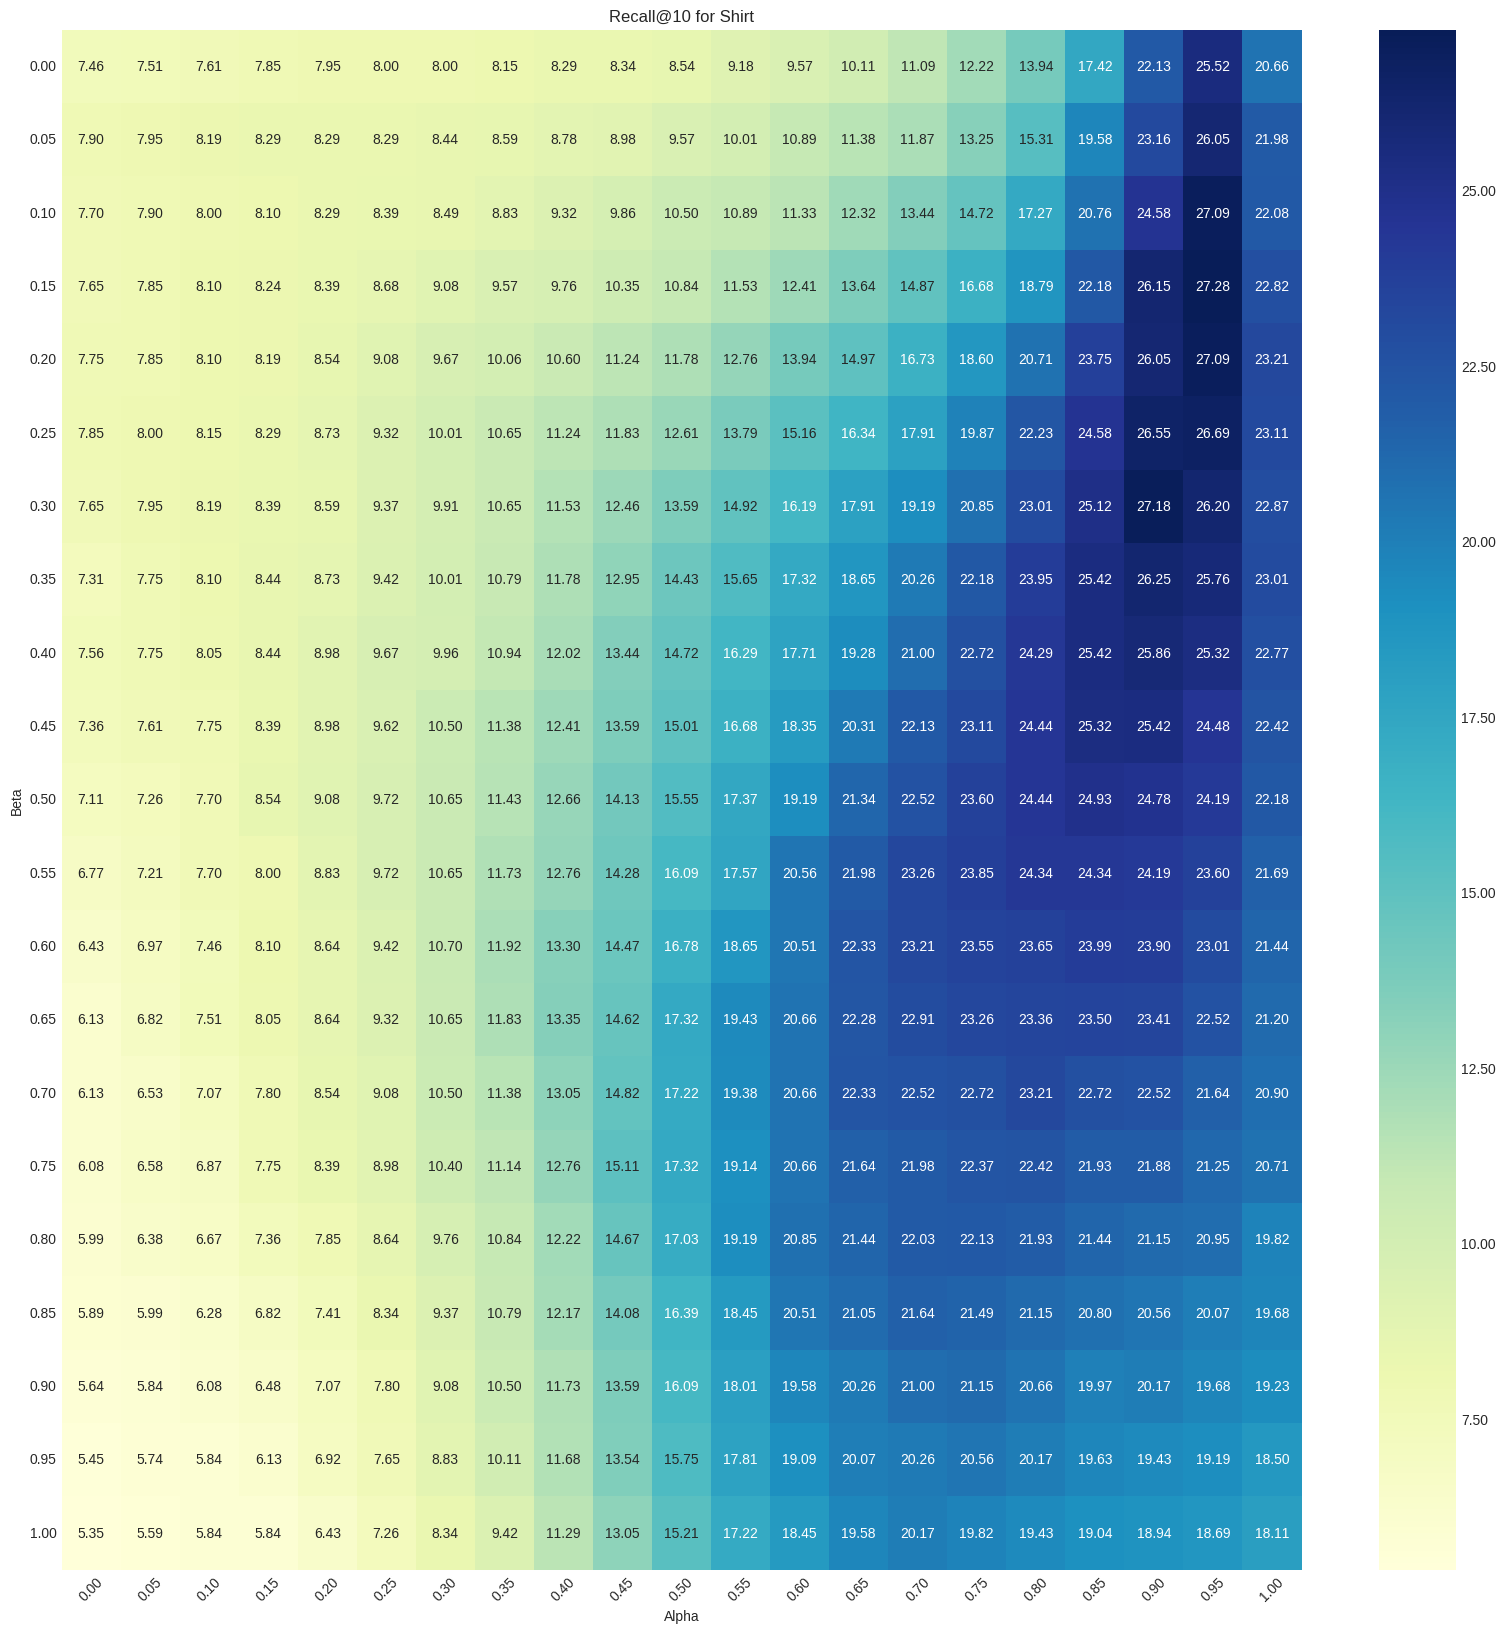

In [20]:
prepare_and_plot_recall_pivot(shirt_recall_at10, "Recall@10 for Shirt")

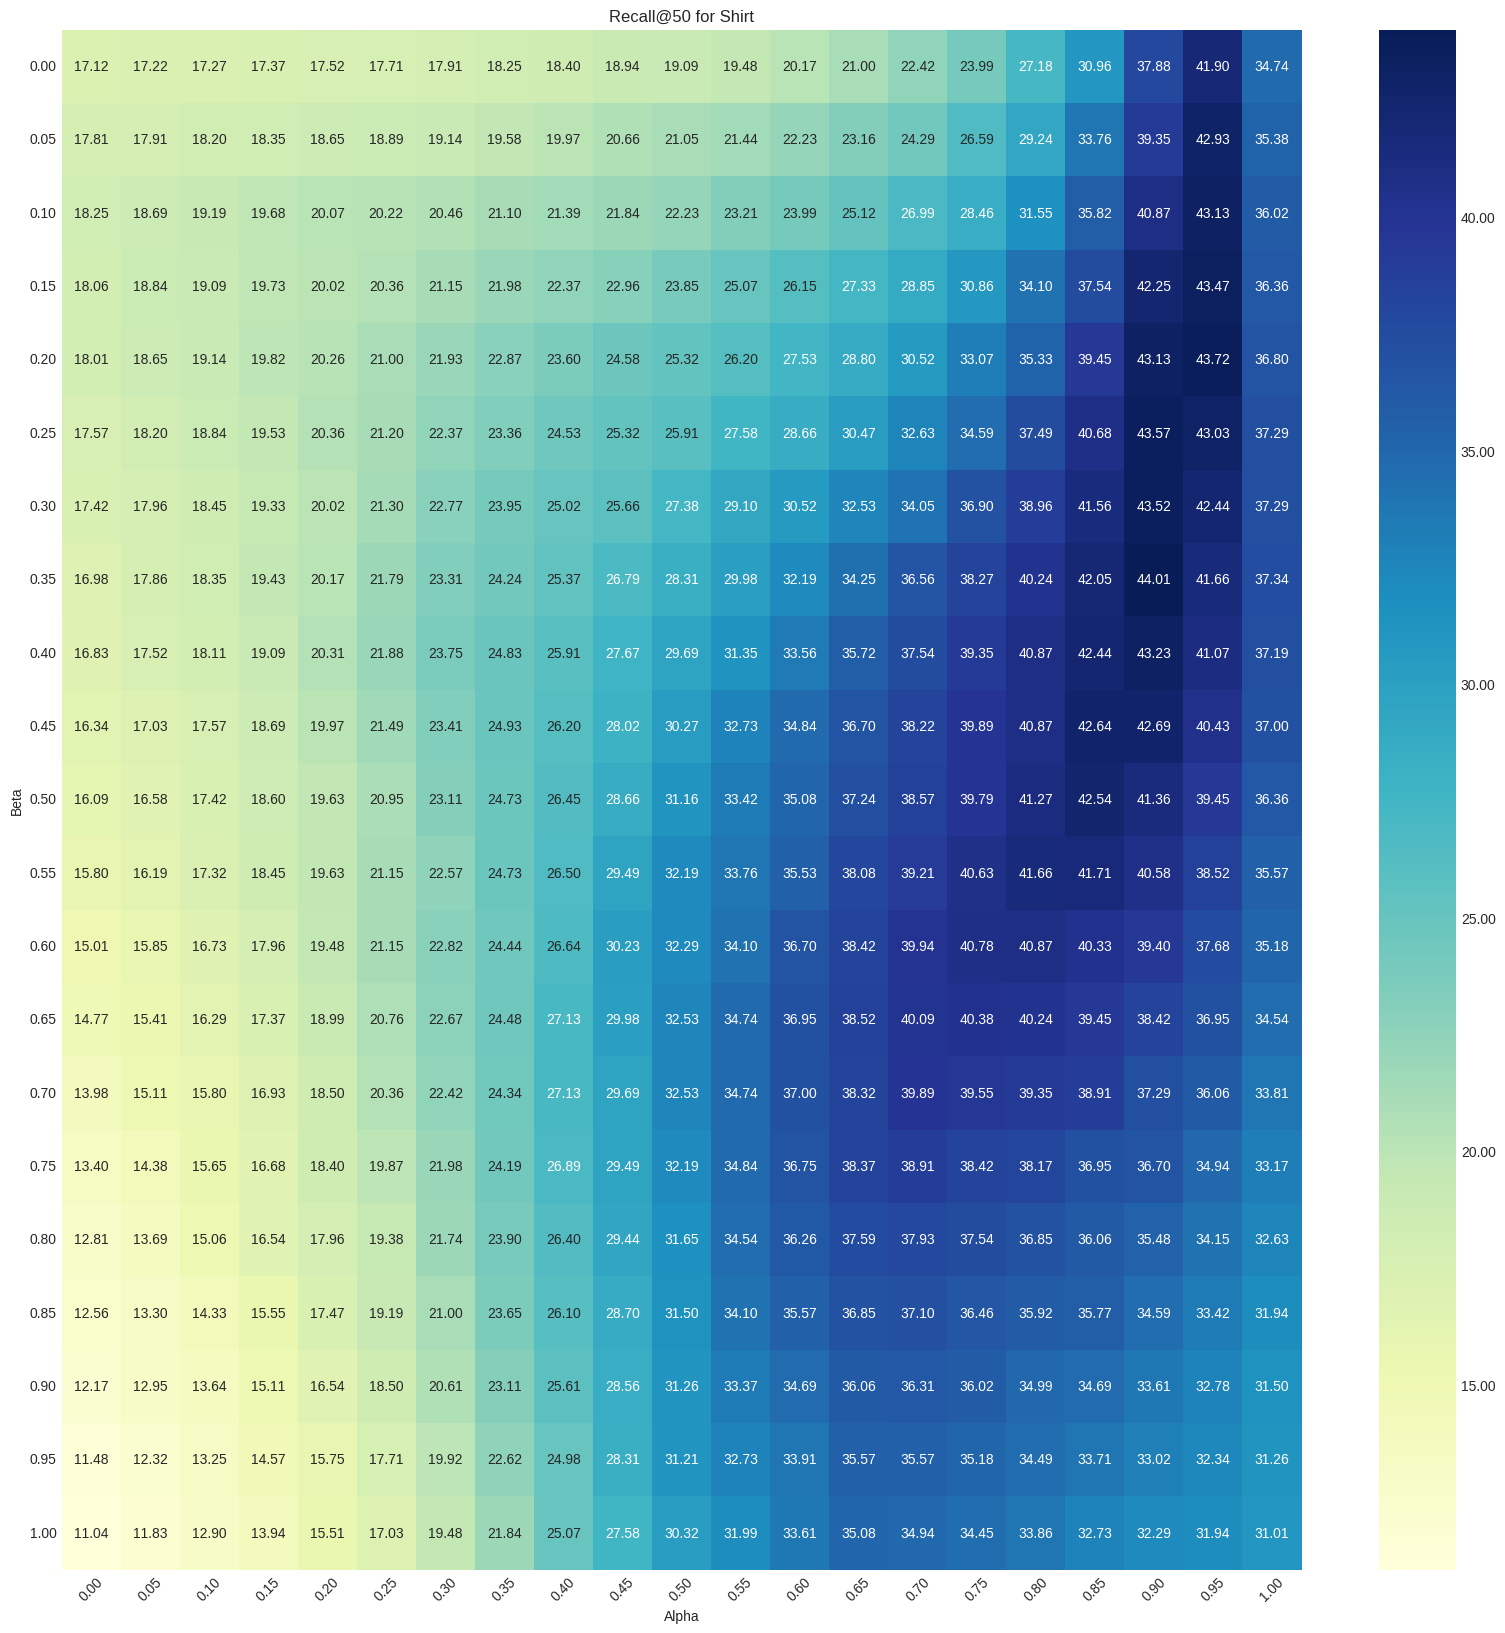

In [21]:
prepare_and_plot_recall_pivot(shirt_recall_at50, "Recall@50 for Shirt")

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the recall at 10 and 50 for Dress</div>

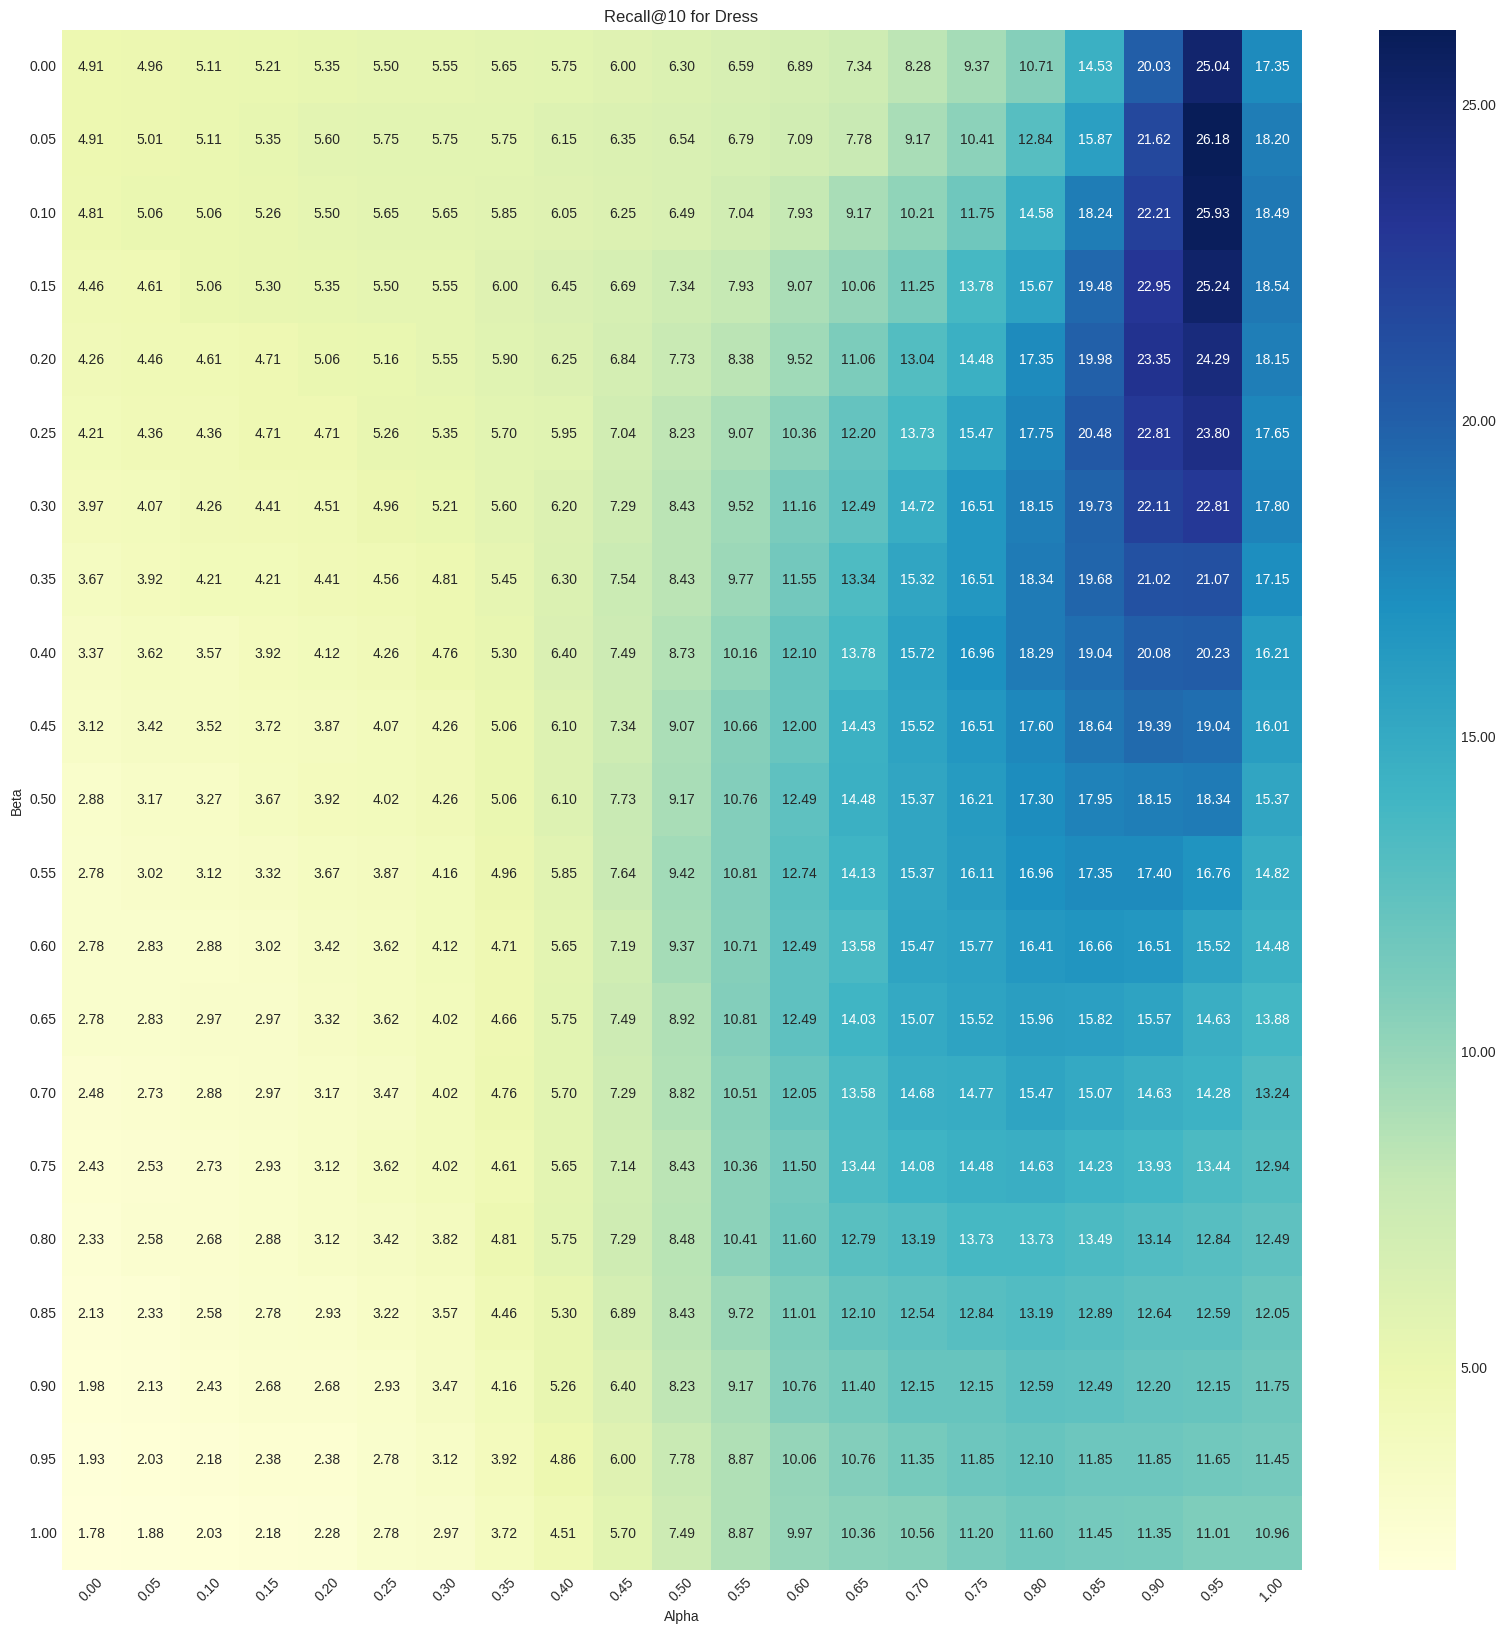

In [22]:
prepare_and_plot_recall_pivot(dress_recall_at10, "Recall@10 for Dress")

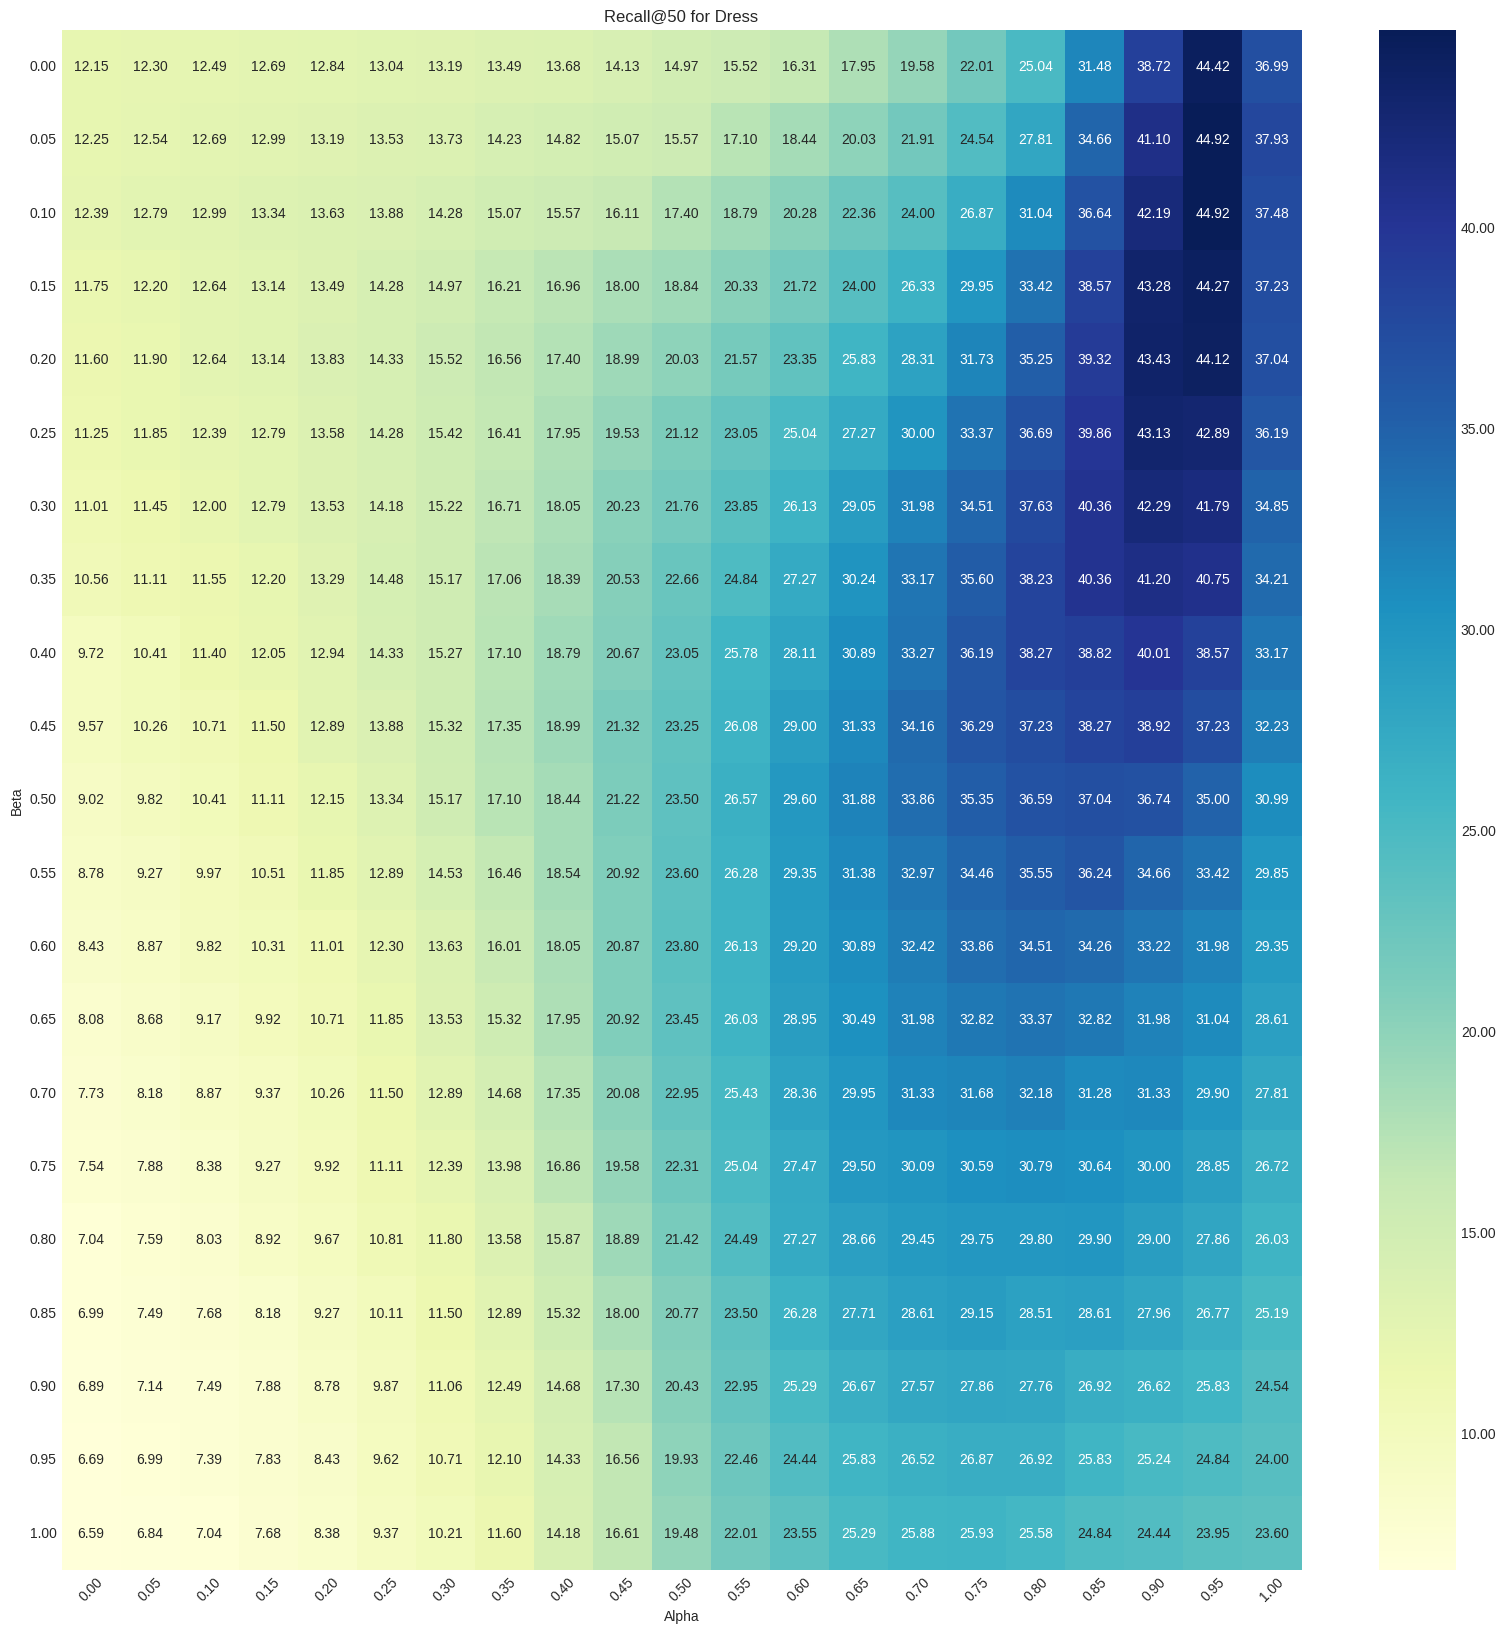

In [23]:
prepare_and_plot_recall_pivot(dress_recall_at50, "Recall@50 for Dress")

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the recall at 10 and 50 for TopTee</div>

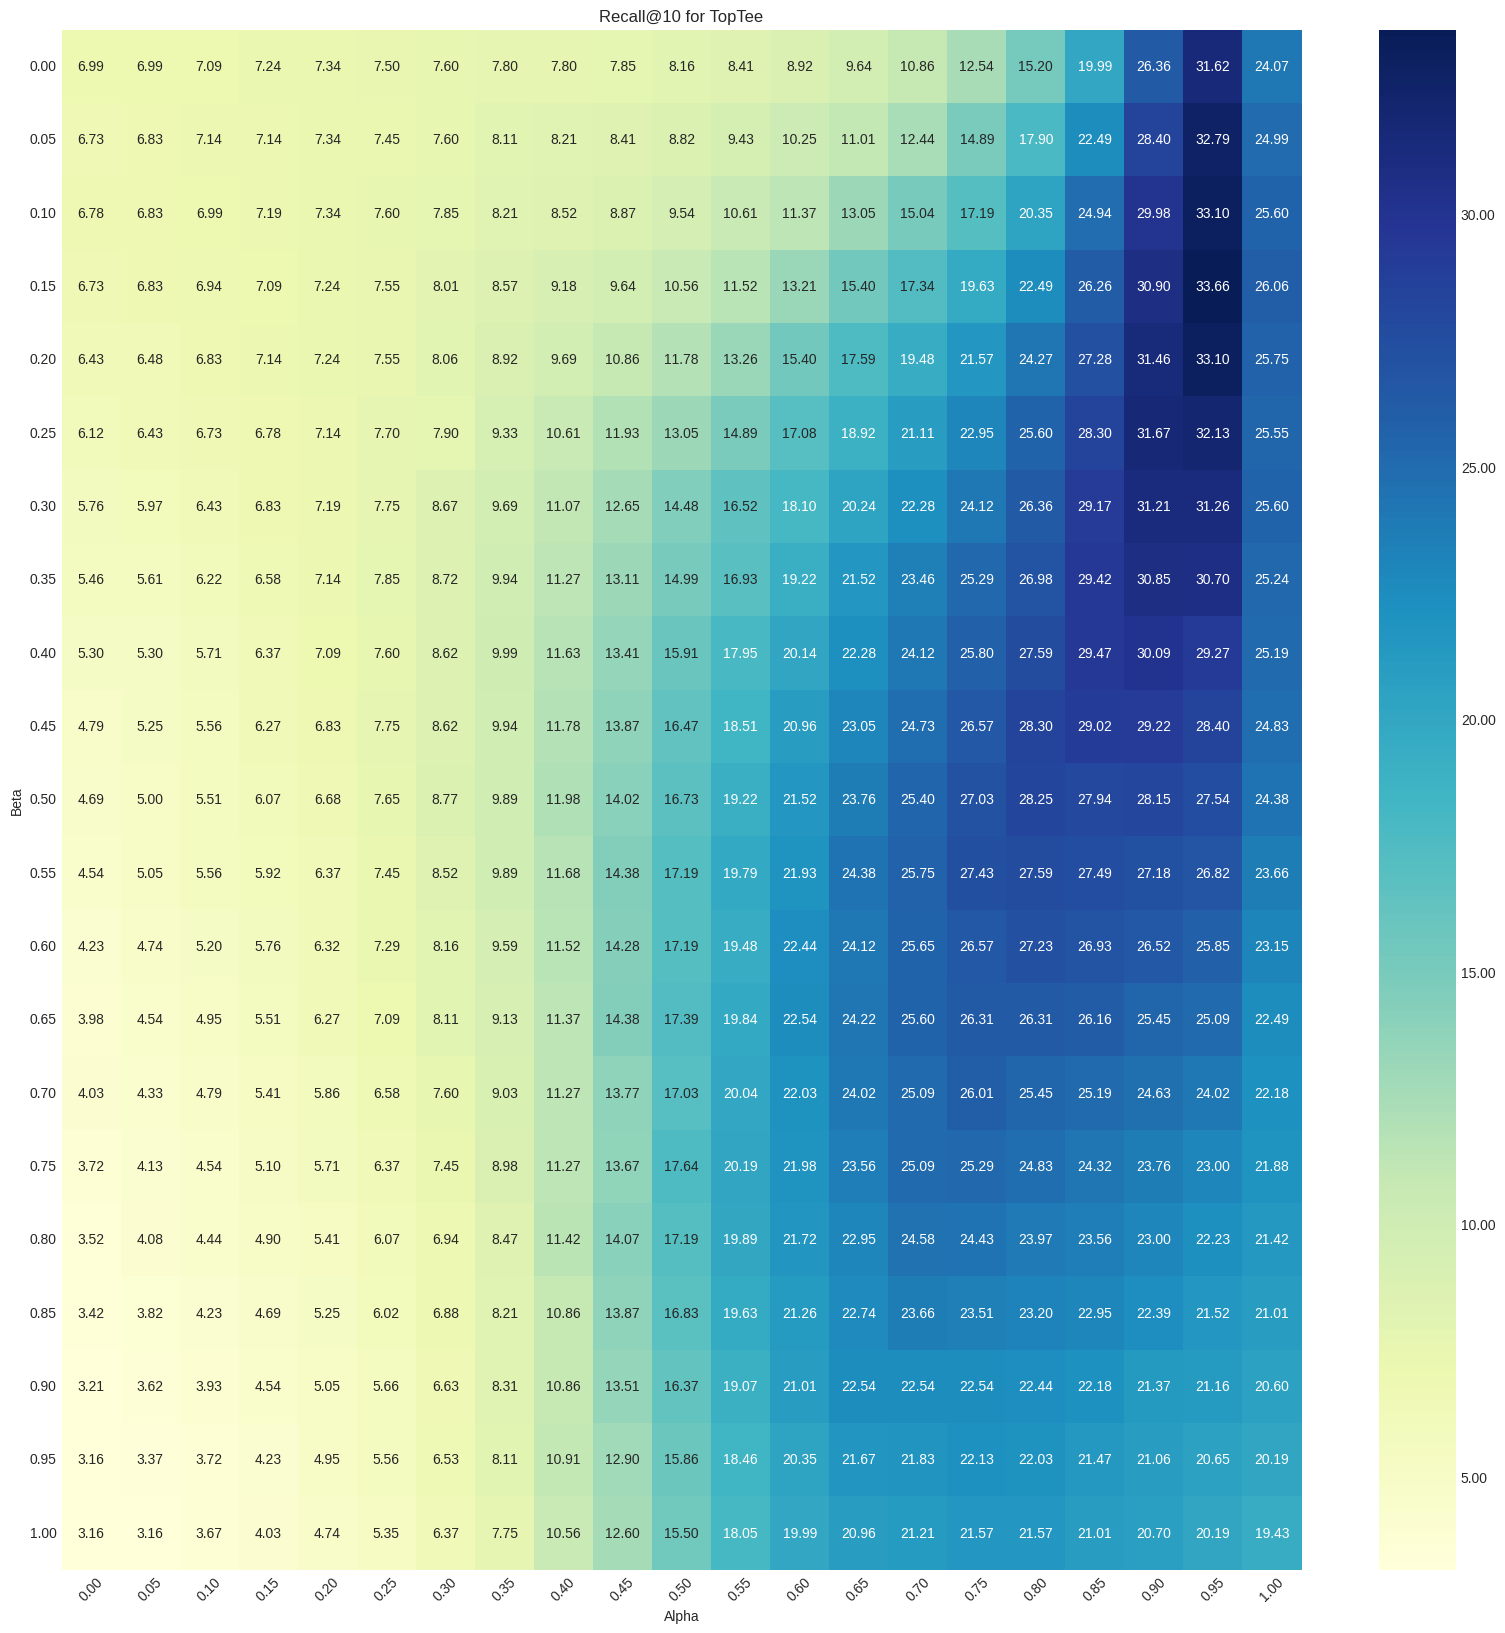

In [24]:
prepare_and_plot_recall_pivot(toptee_recall_at10, "Recall@10 for TopTee")

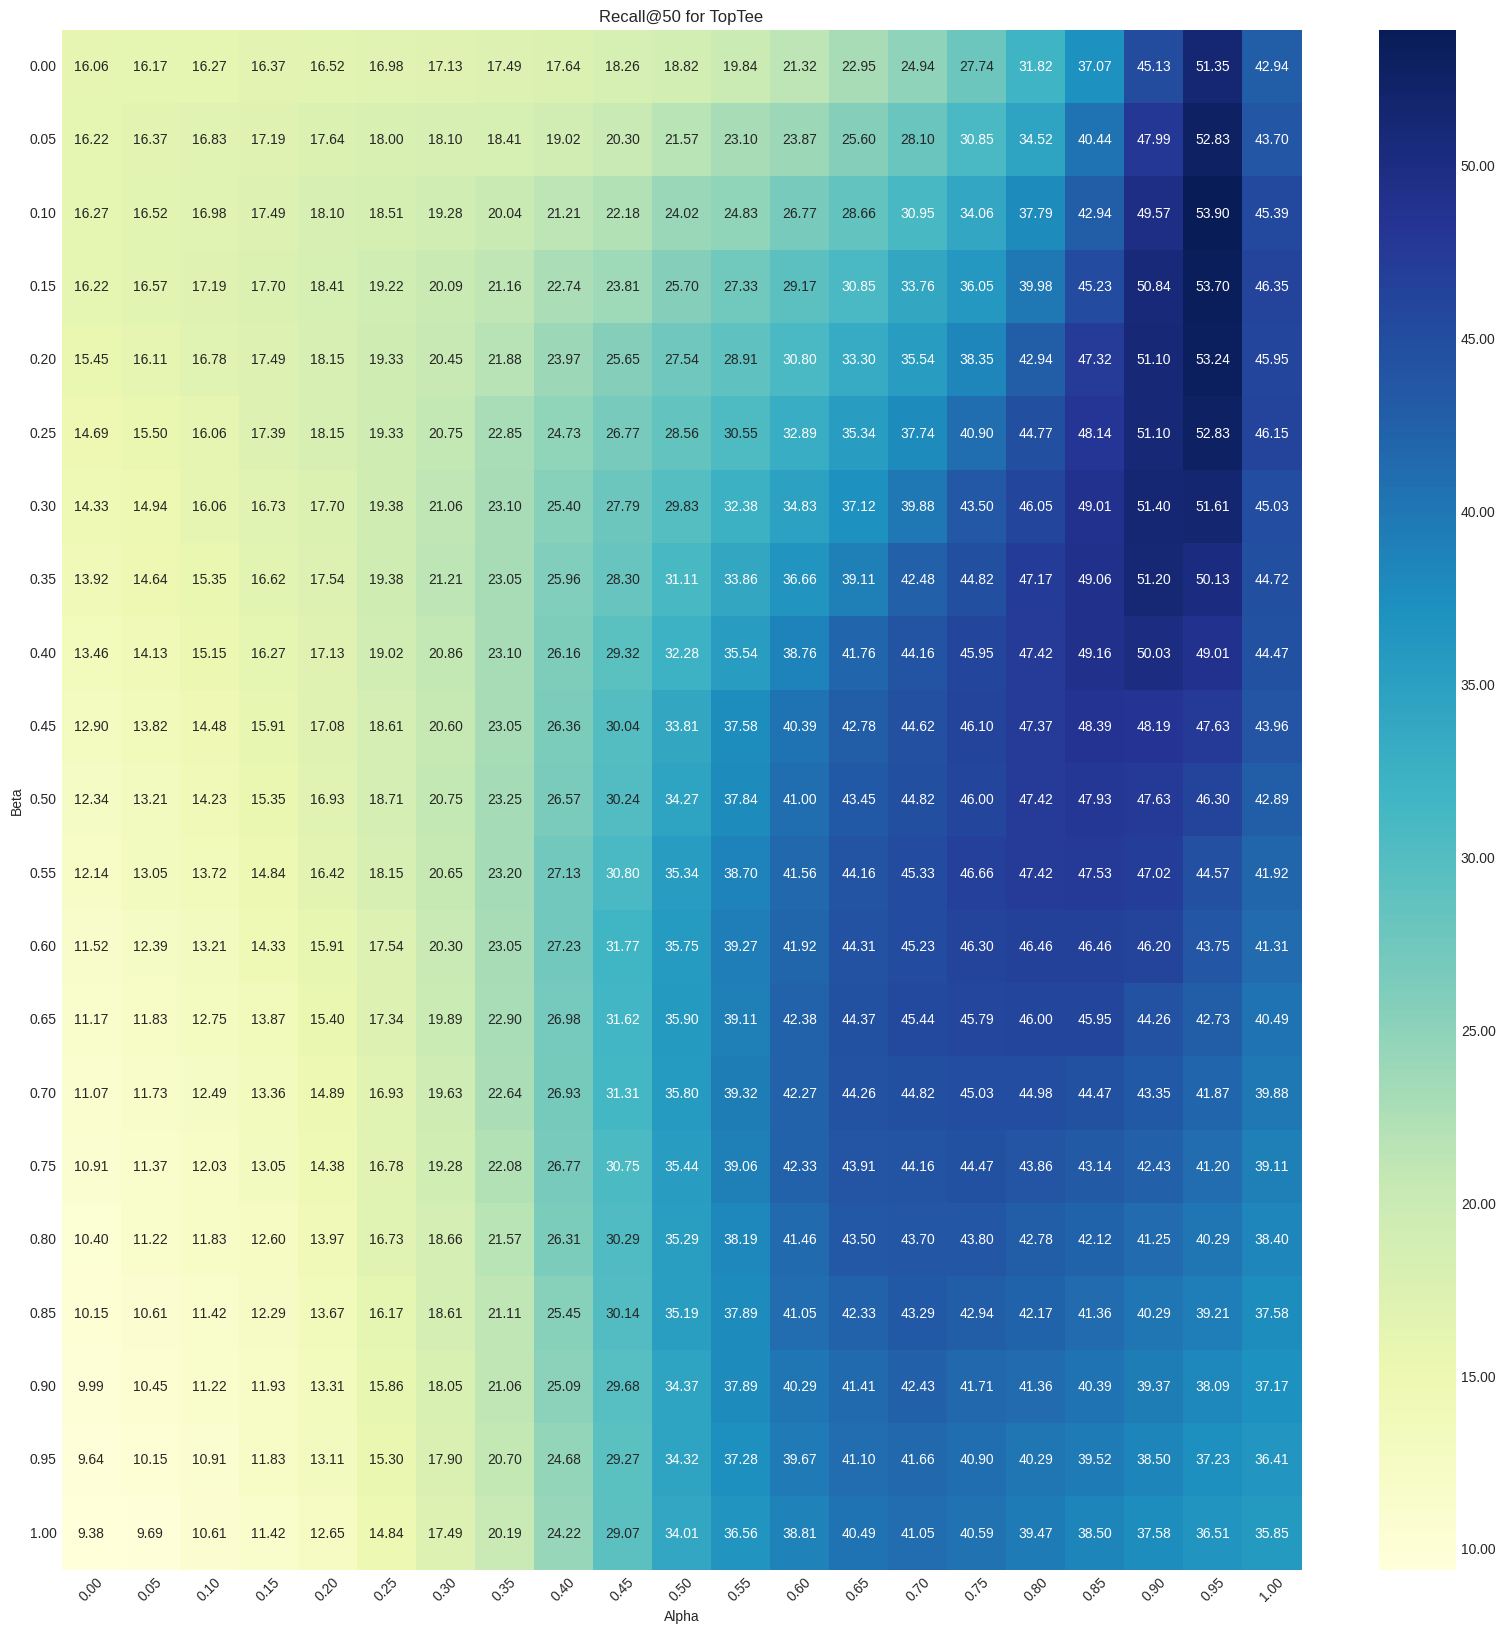

In [25]:
prepare_and_plot_recall_pivot(toptee_recall_at50, "Recall@50 for TopTee")

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the average recall at 10 and 50 for all categories</div>

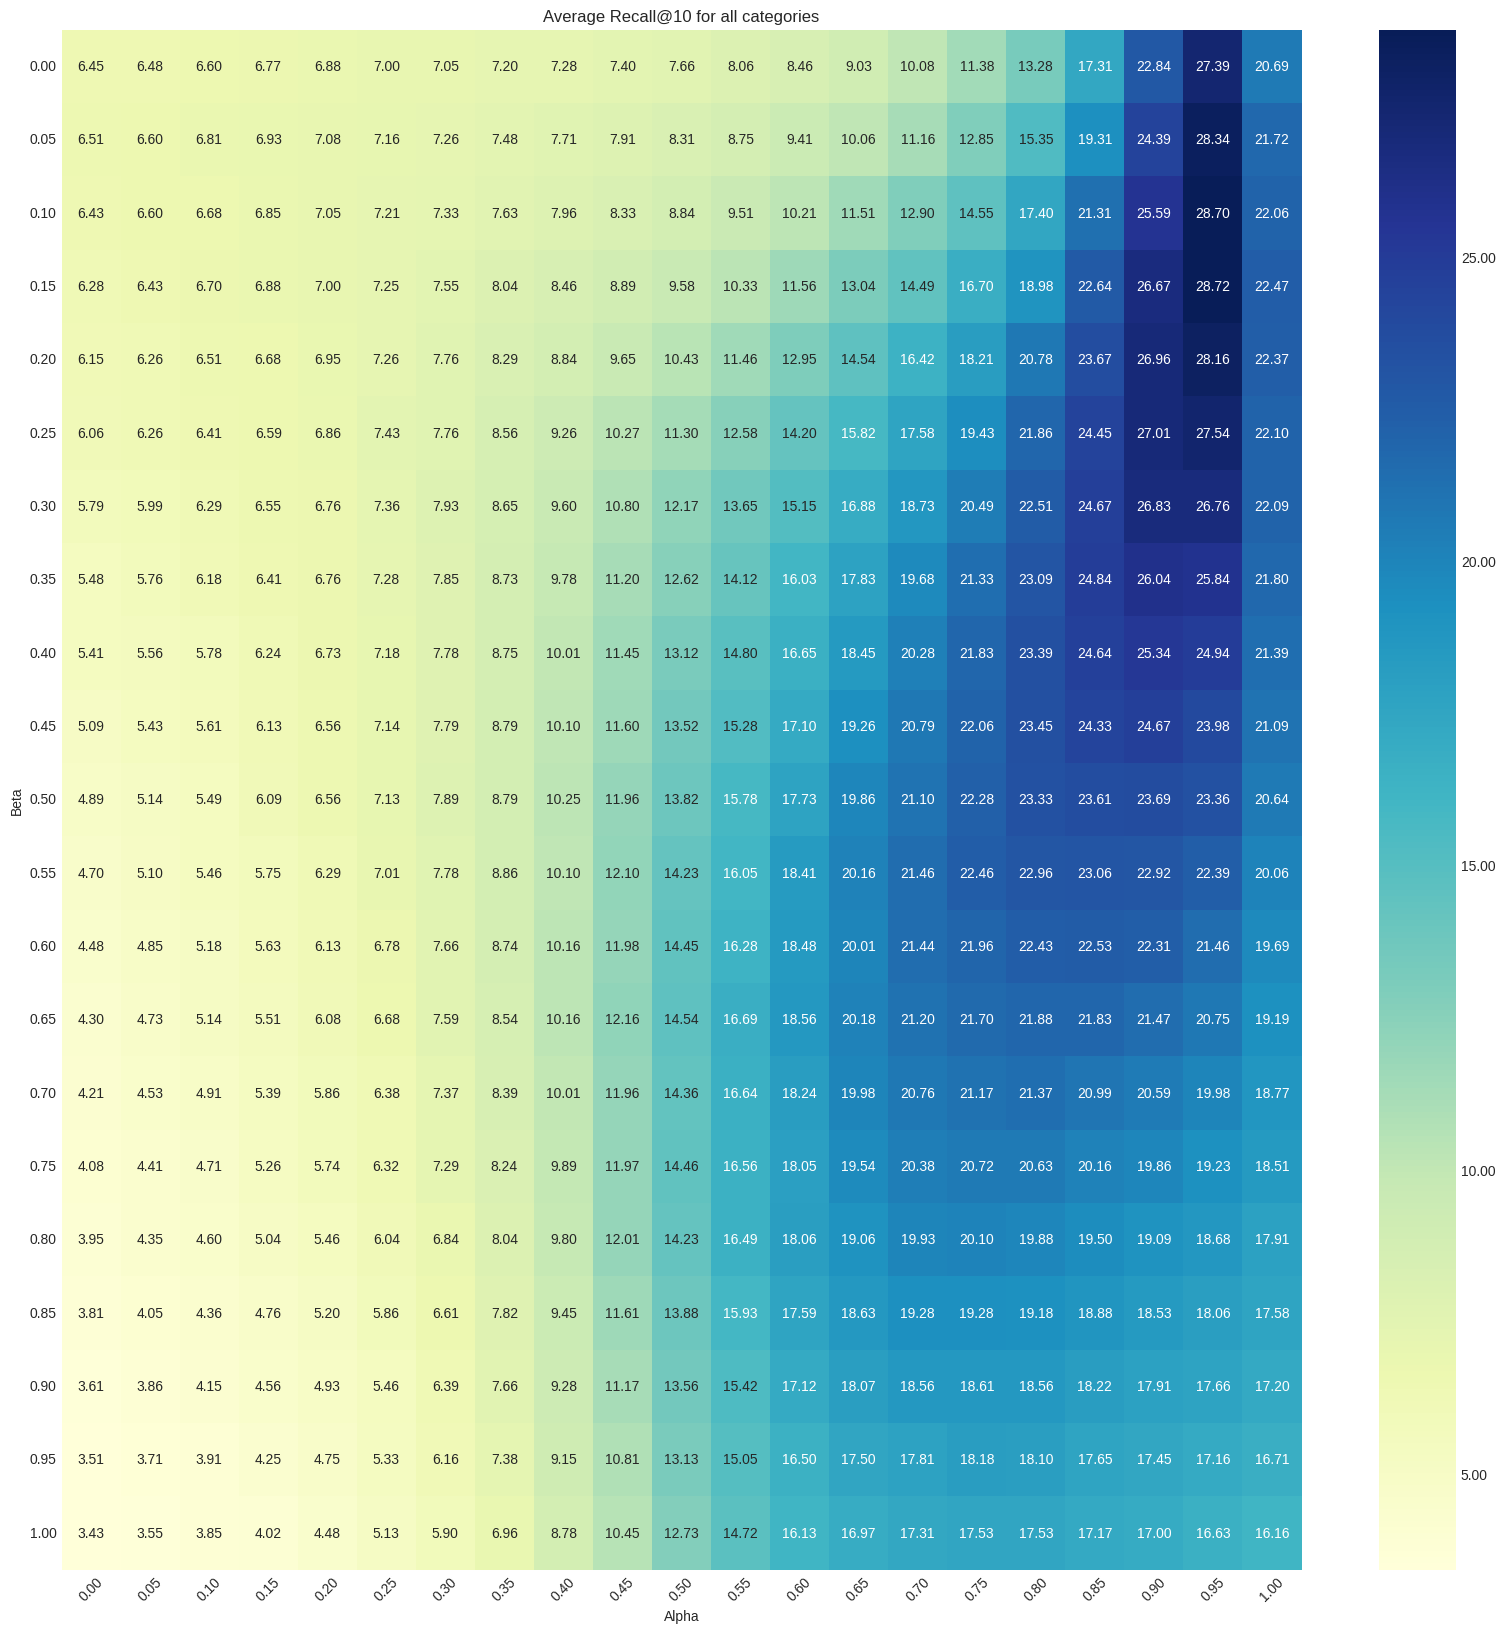

In [26]:
prepare_and_plot_recall_pivot(average_recall_at10, "Average Recall@10 for all categories")

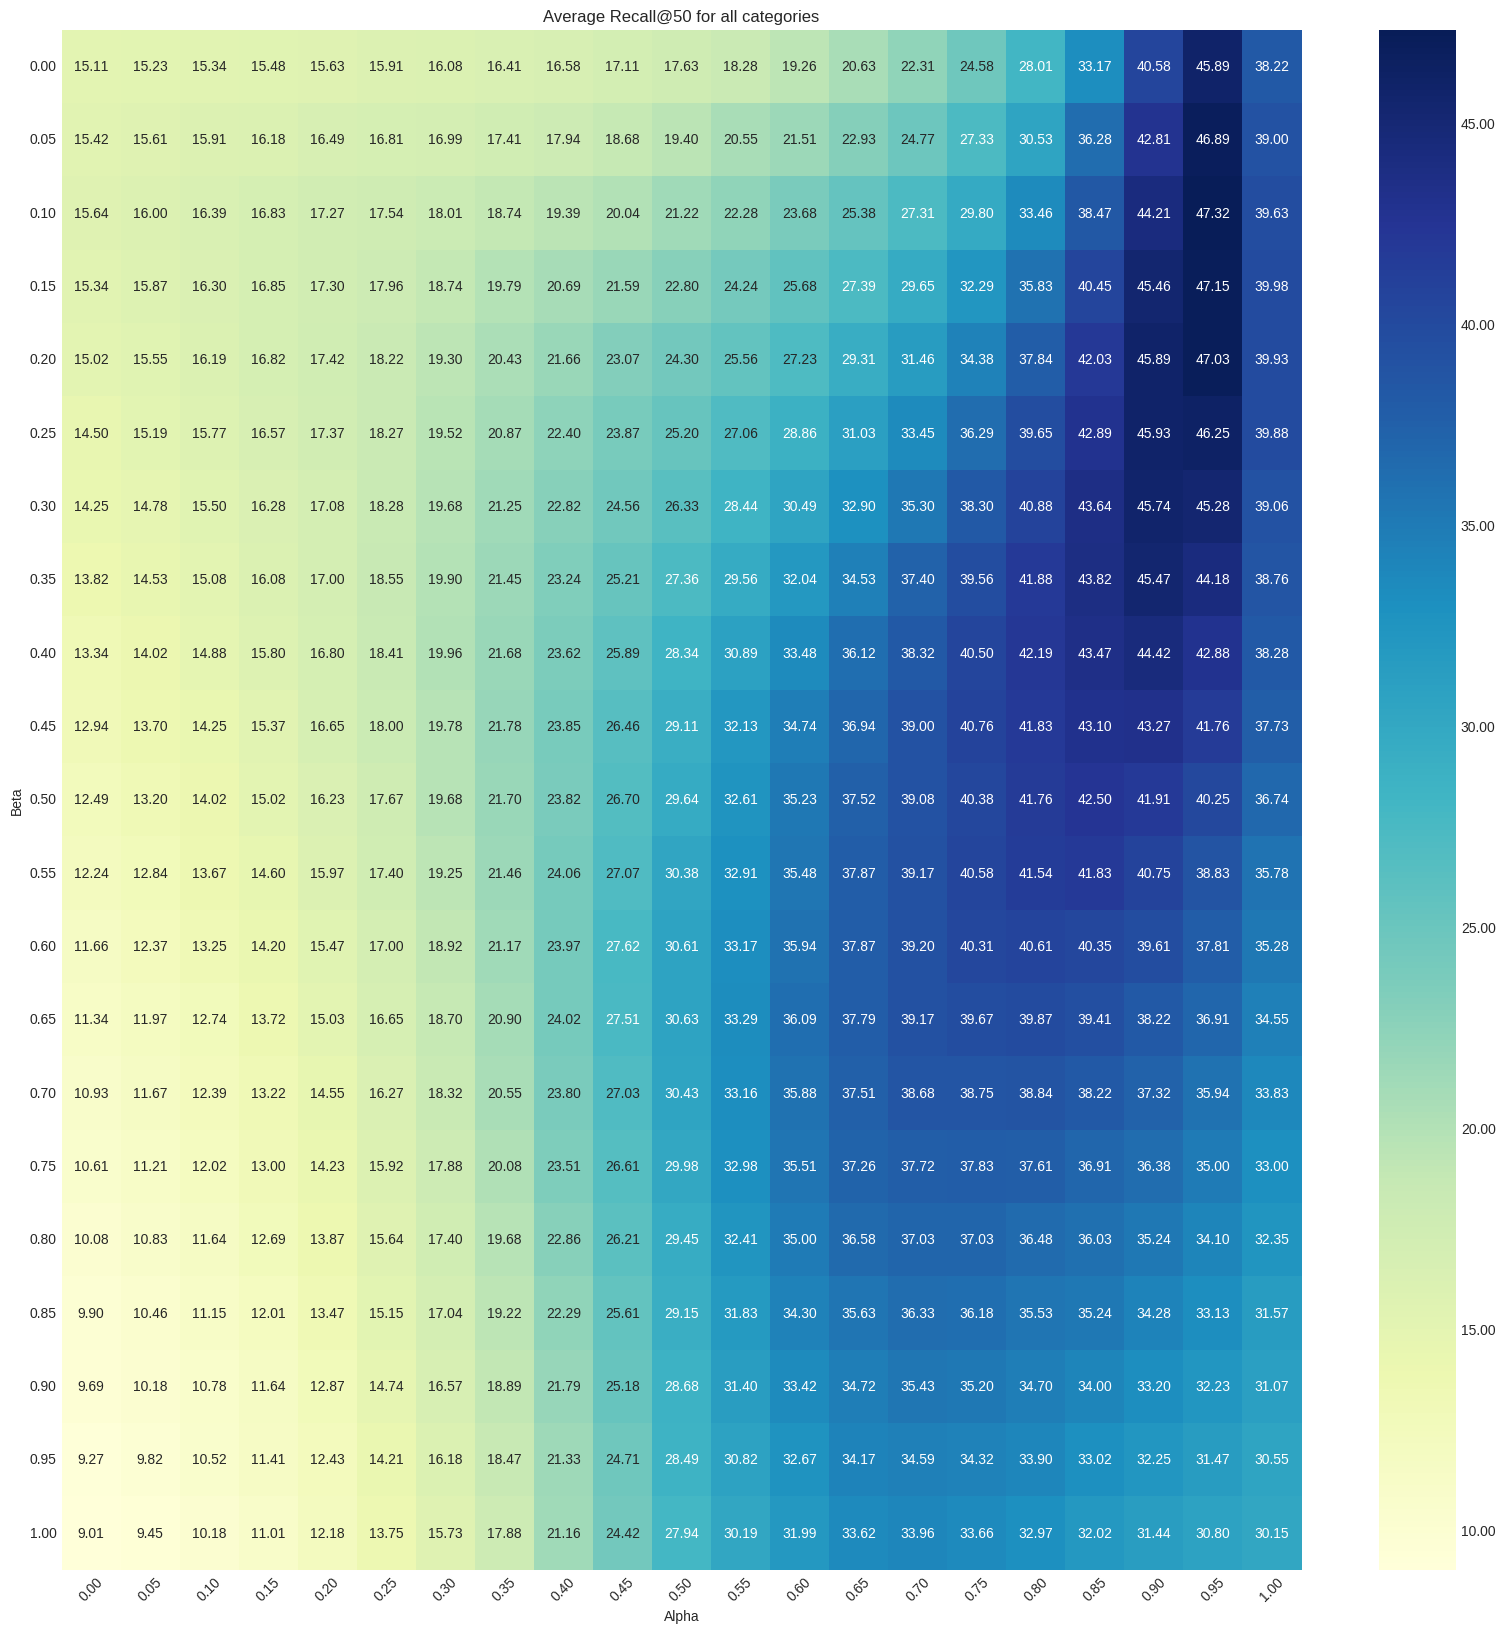

In [27]:
prepare_and_plot_recall_pivot(average_recall_at50, "Average Recall@50 for all categories")

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 5: View some sample of the result</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the Shirt category</div>

In [29]:
sorted_indices_shirt, image_index_names_shirt, target_names_shirt = compute_results_fiq_val(
    'shirt',
    get_combing_function_with_alpha(0.95),
    blip_text_encoder,
    blip_img_encoder,
    text_captions,
    preprocess,
    beta=0.2,
    cache=cache,
)

Recall at 10: 27.085378766059875
Recall at 50: 43.71933341026306


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the Dress category</div>

In [28]:
sorted_indices_dress, image_index_names_dress, target_names_dress = compute_results_fiq_val(
    'dress',
    get_combing_function_with_alpha(0.95),
    blip_text_encoder,
    blip_img_encoder,
    text_captions,
    preprocess,
    beta=0.2,
    cache=cache,
)

Recall at 10: 24.293504655361176
Recall at 50: 44.12493705749512


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the TopTee category</div>

In [30]:
sorted_indices_toptee, image_index_names_toptee, target_names_toptee = compute_results_fiq_val(
    'toptee',
    get_combing_function_with_alpha(0.95),
    blip_text_encoder,
    blip_img_encoder,
    text_captions,
    preprocess,
    beta=0.2,
    cache=cache,
)

Recall at 10: 33.095359802246094
Recall at 50: 53.23814153671265


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Prepare the ground truth data</div>

In [31]:
ground_truth_dress = prepare_ground_truths(json.load(open('../../../fashionIQ_dataset/captions/cap.dress.val.json')))
ground_truth_shirt = prepare_ground_truths(json.load(open('../../../fashionIQ_dataset/captions/cap.shirt.val.json')))
ground_truth_toptee = prepare_ground_truths(json.load(open('../../../fashionIQ_dataset/captions/cap.toptee.val.json')))

DATASET_IMAGE_DIR = '../../../fashionIQ_dataset/images/'

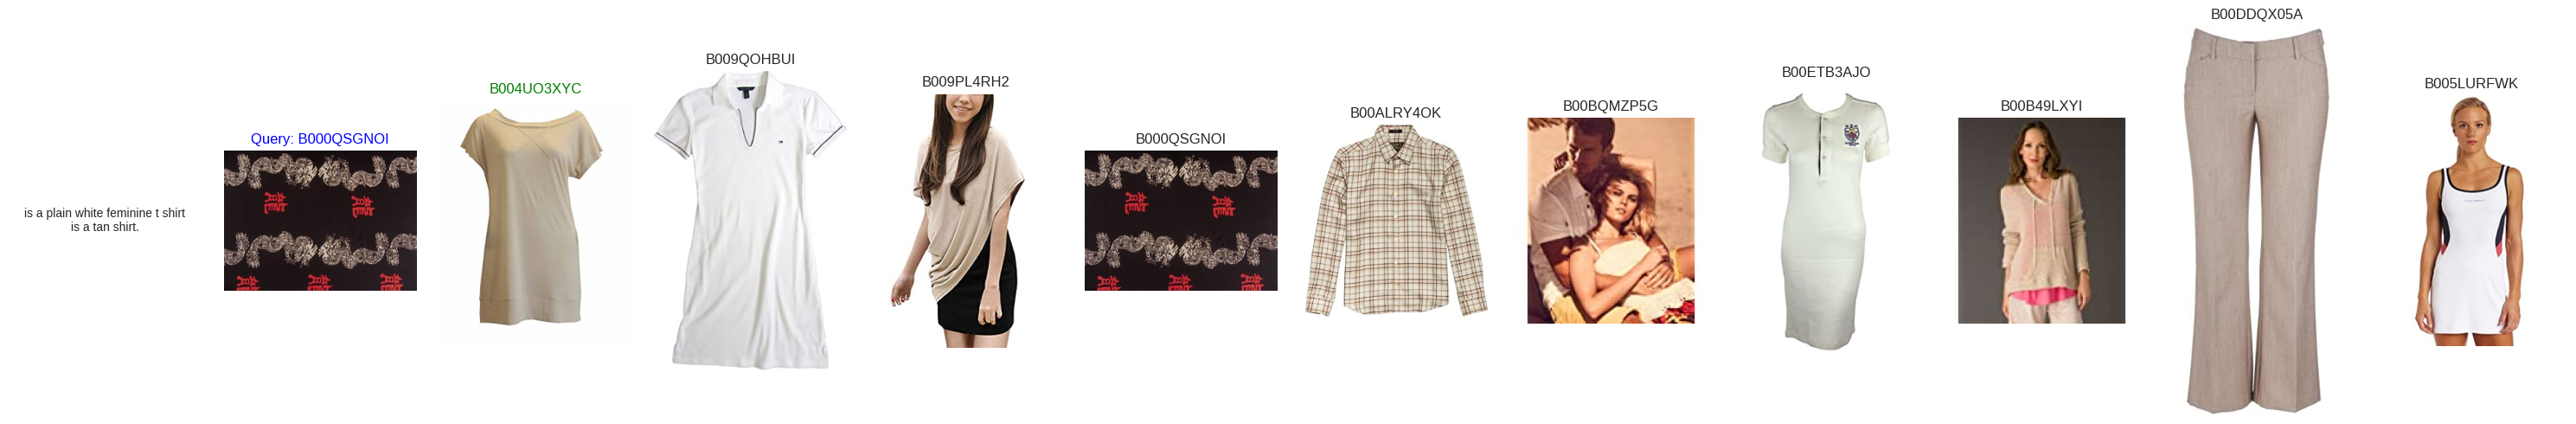

In [32]:
plot_retrieval_results_of_i(
    sorted_indices_dress, 
    image_index_names_dress, 
    target_names_dress, 
    ground_truth_dress, 
    top_k=10, 
    i=3,
    directory=DATASET_IMAGE_DIR,
)

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 6: Compare with the original without MMLM captions and identical weights element-wise sum</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the Shirt category</div>

In [34]:
sorted_indices_shirt_origin, image_index_names_shirt_origin, target_names_shirt_origin = compute_results_fiq_val(
    'shirt',
    combining_function_original,
    blip_text_encoder,
    blip_img_encoder,
    text_captions,
    preprocess,
    beta=0,
    cache=cache,
)

Recall at 10: 8.537781983613968
Recall at 50: 19.08733993768692


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the Dress category</div>

In [33]:
sorted_indices_dress_origin, image_index_names_dress_origin, target_names_dress_origin = compute_results_fiq_val(
    'dress',
    combining_function_original,
    blip_text_encoder,
    blip_img_encoder,
    text_captions,
    preprocess,
    beta=0,
    cache=cache,
)

Recall at 10: 6.29647970199585
Recall at 50: 14.972731471061707


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the TopTee category</div>

In [35]:
sorted_indices_toptee_origin, image_index_names_toptee_origin, target_names_toptee_origin = compute_results_fiq_val(
    'toptee',
    combining_function_original,
    blip_text_encoder,
    blip_img_encoder,
    text_captions,
    preprocess,
    beta=0,
    cache=cache,
)

Recall at 10: 8.159102499485016
Recall at 50: 18.816930055618286


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compare the results for the Shirt category</div>

In [38]:
become_better = found_better_than_original(
    sorted_indices_shirt_origin, image_index_names_shirt_origin, target_names_shirt_origin,
    sorted_indices_shirt, image_index_names_shirt, target_names_shirt,
    top_k=10
)

len(become_better), become_better[:10]

(464, [1, 6, 8, 13, 16, 19, 20, 21, 24, 32])

In [39]:
become_worse = found_better_than_original(
    sorted_indices_shirt, image_index_names_shirt, target_names_shirt,
    sorted_indices_shirt_origin, image_index_names_shirt_origin, target_names_shirt_origin,
    top_k=10
)

len(become_worse), become_worse[:10]

(75, [5, 10, 84, 117, 134, 138, 150, 174, 183, 187])

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compare the results for the Dress category</div>

In [36]:
become_better = found_better_than_original(
    sorted_indices_dress_origin, image_index_names_dress_origin, target_names_dress_origin,
    sorted_indices_dress, image_index_names_dress, target_names_dress,
    top_k=10
)

len(become_better), become_better[:10]

(439, [1, 3, 4, 19, 27, 30, 33, 34, 38, 52])

In [37]:
become_worse = found_better_than_original(
    sorted_indices_dress, image_index_names_dress, target_names_dress,
    sorted_indices_dress_origin, image_index_names_dress_origin, target_names_dress_origin,
    top_k=10
)

len(become_worse), become_worse[:10]

(61, [61, 109, 169, 215, 218, 308, 352, 459, 496, 520])

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compare the results for the TopTee category</div>

In [40]:
become_better = found_better_than_original(
    sorted_indices_toptee_origin, image_index_names_toptee_origin, target_names_toptee_origin,
    sorted_indices_toptee, image_index_names_toptee, target_names_toptee,
    top_k=10
)

len(become_better), become_better[:10]

(576, [2, 3, 4, 7, 9, 10, 13, 18, 20, 24])

In [41]:
become_worse = found_better_than_original(
    sorted_indices_toptee, image_index_names_toptee, target_names_toptee,
    sorted_indices_toptee_origin, image_index_names_toptee_origin, target_names_toptee_origin,
    top_k=10
)

len(become_worse), become_worse[:10]

(61, [0, 63, 117, 176, 216, 241, 256, 292, 377, 378])

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 7: Visualize the comparison</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the results for the Shirt category</div>

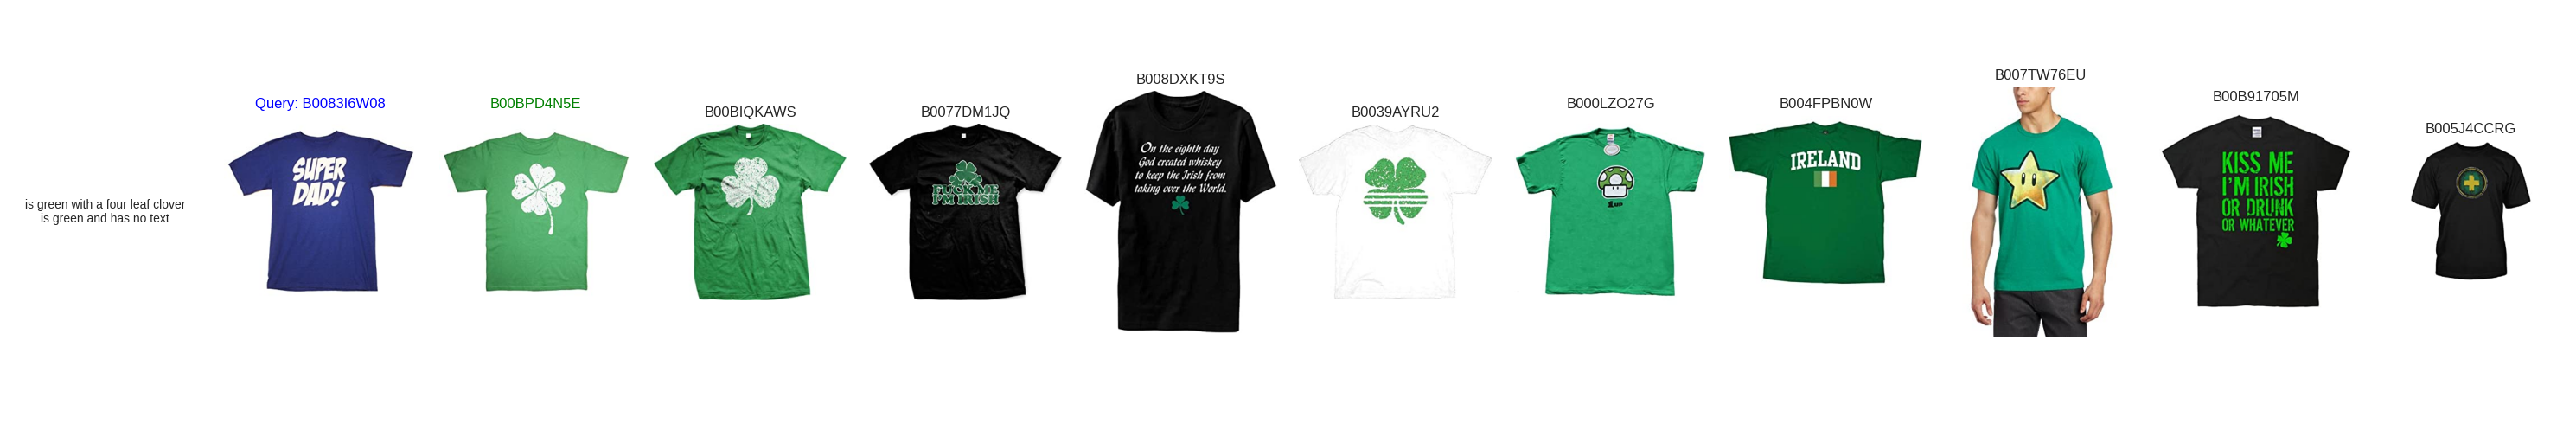

In [44]:
plot_retrieval_results_of_i(sorted_indices_shirt, image_index_names_shirt, target_names_shirt, ground_truth_shirt, top_k=10, i=1, directory=DATASET_IMAGE_DIR)

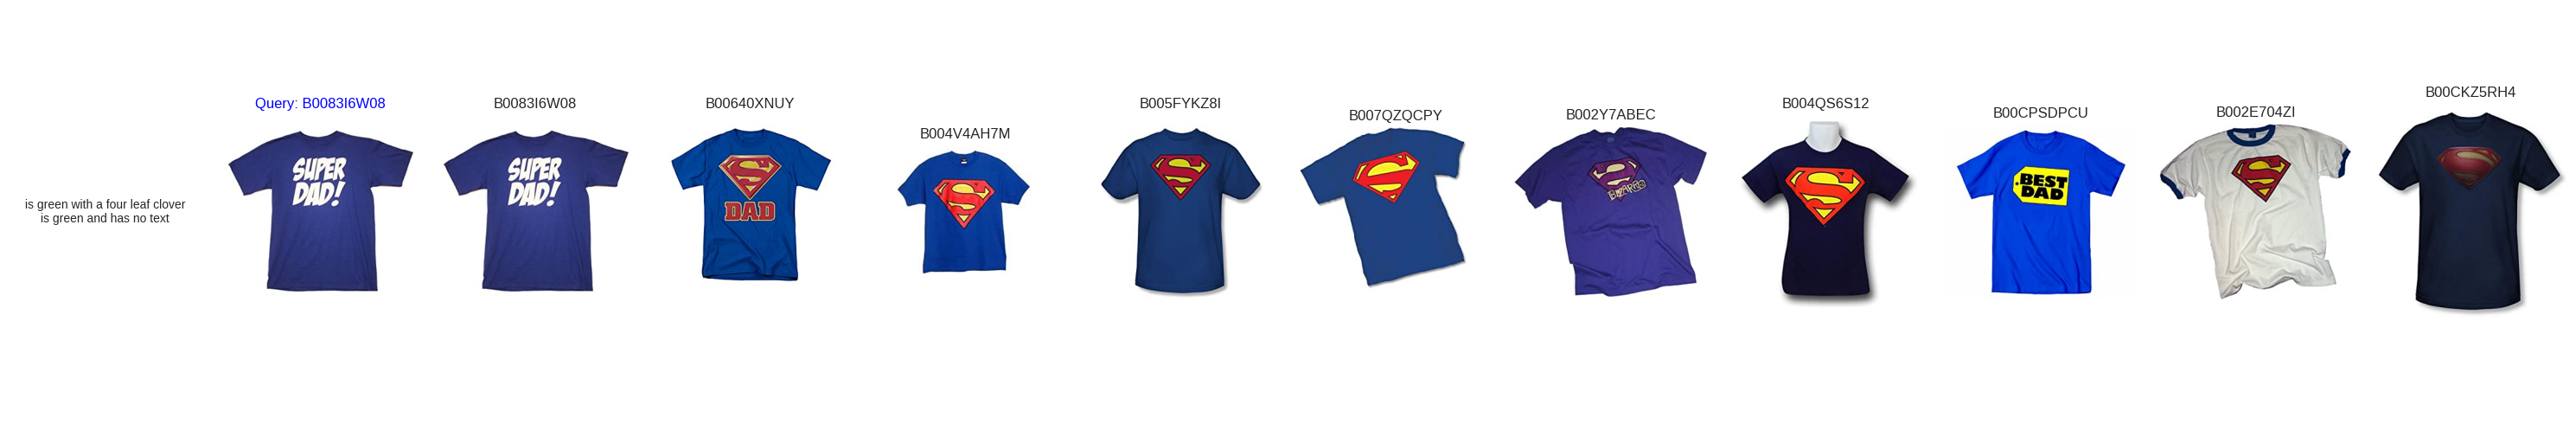

In [45]:
plot_retrieval_results_of_i(sorted_indices_shirt_origin, image_index_names_shirt_origin, target_names_shirt_origin, ground_truth_shirt, top_k=10, i=1, directory=DATASET_IMAGE_DIR)

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the results for the Dress category</div>

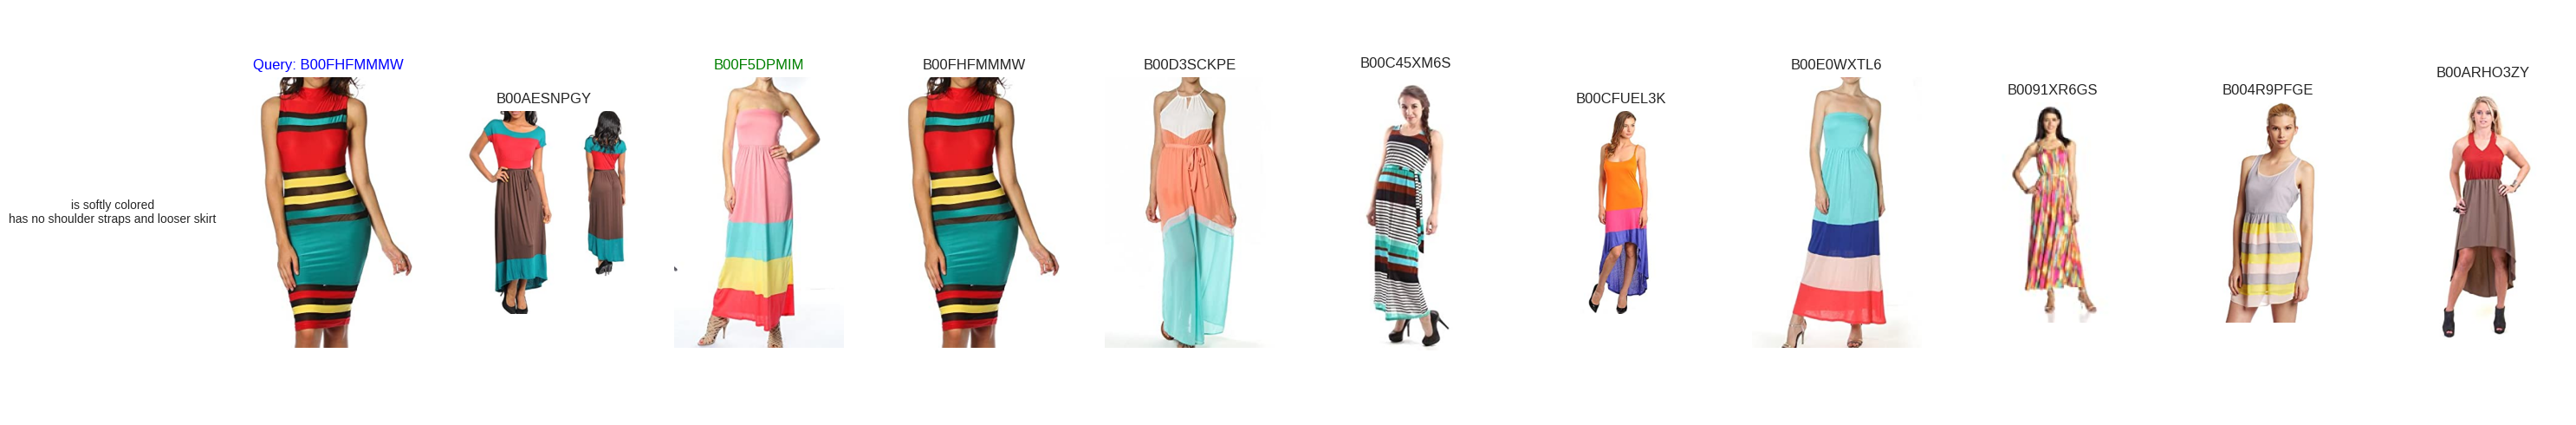

In [42]:
plot_retrieval_results_of_i(sorted_indices_dress, image_index_names_dress, target_names_dress, ground_truth_dress, top_k=10, i=11, directory=DATASET_IMAGE_DIR)

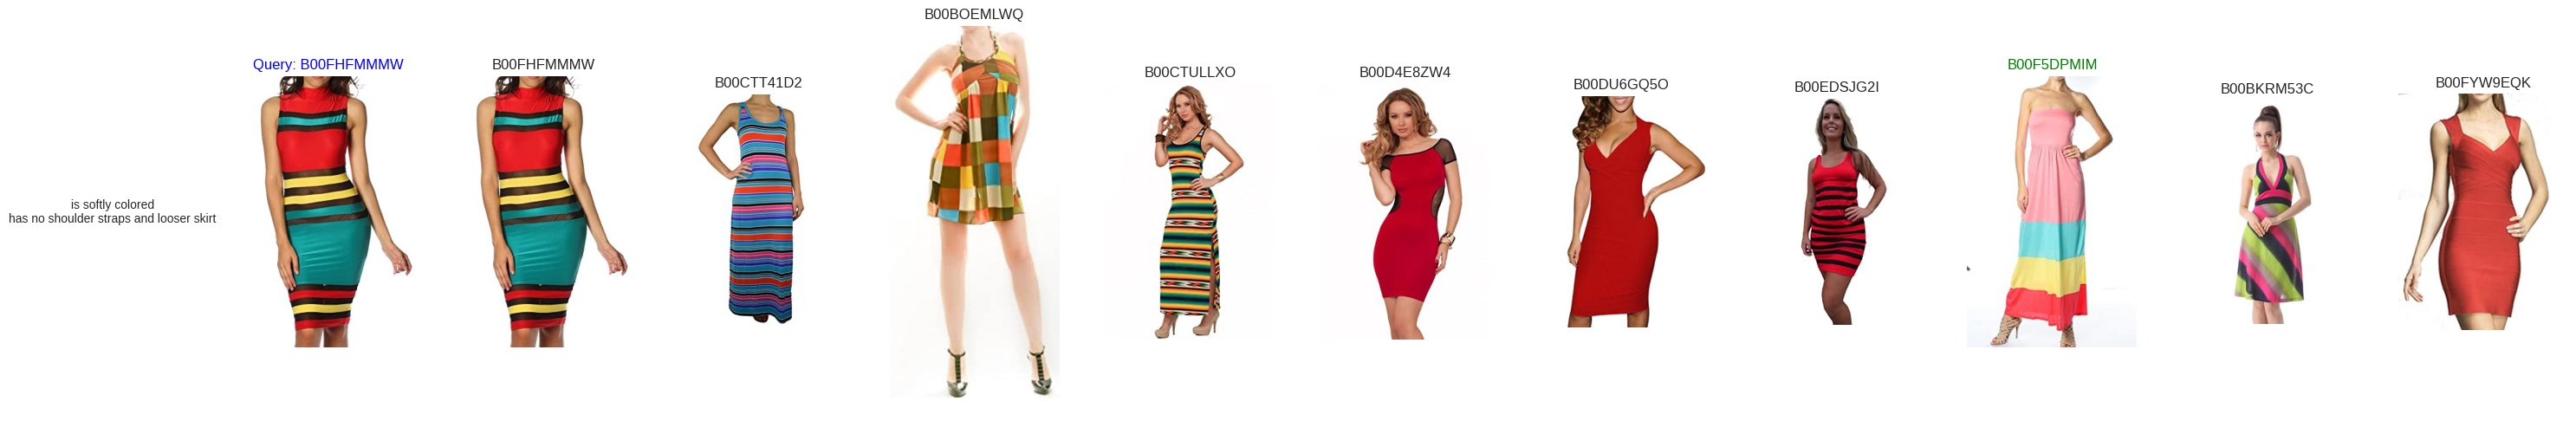

In [43]:
plot_retrieval_results_of_i(sorted_indices_dress_origin, image_index_names_dress_origin, target_names_dress_origin, ground_truth_dress, top_k=10, i=11, directory=DATASET_IMAGE_DIR)

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the results for the TopTee category</div>

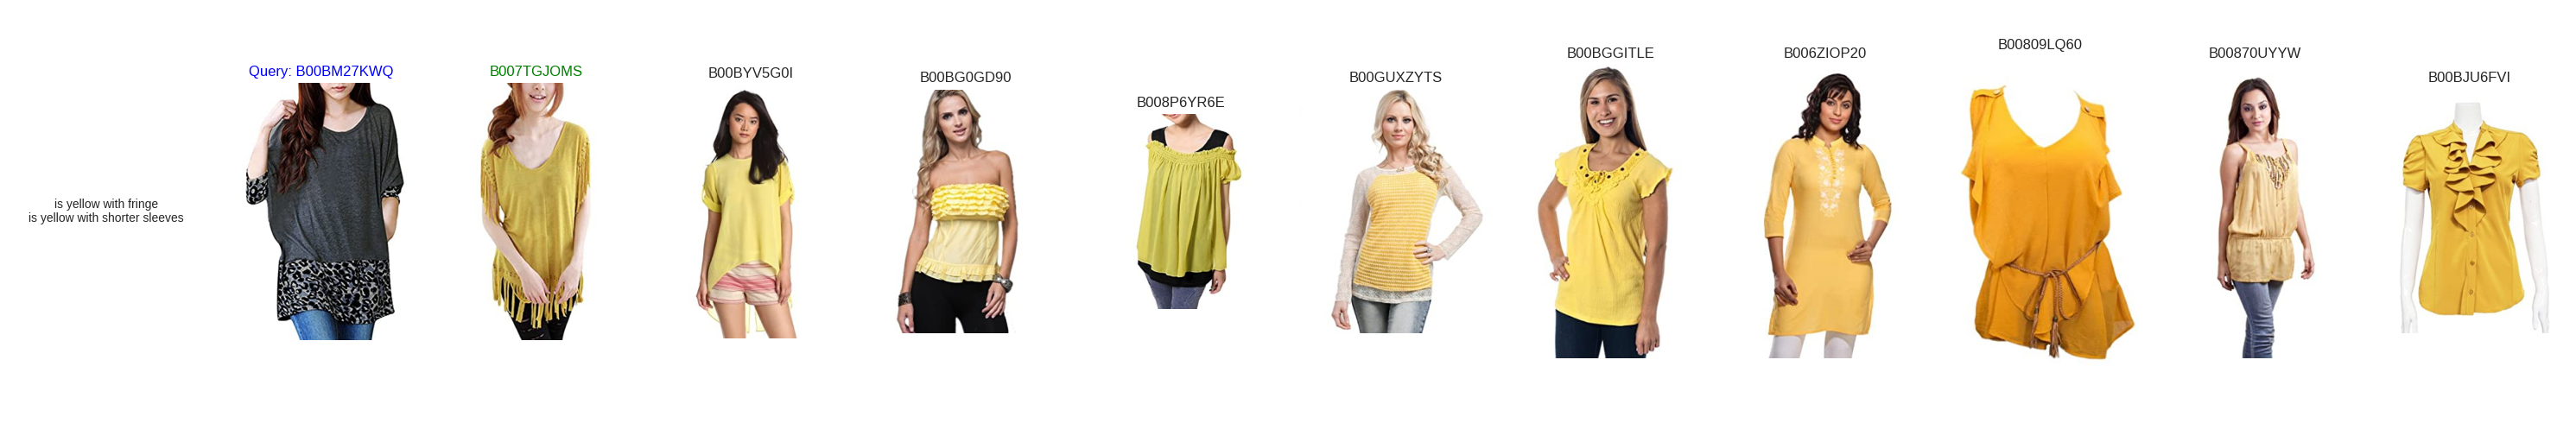

In [46]:
plot_retrieval_results_of_i(sorted_indices_toptee, image_index_names_toptee, target_names_toptee, ground_truth_toptee, top_k=10, i=2, directory=DATASET_IMAGE_DIR)

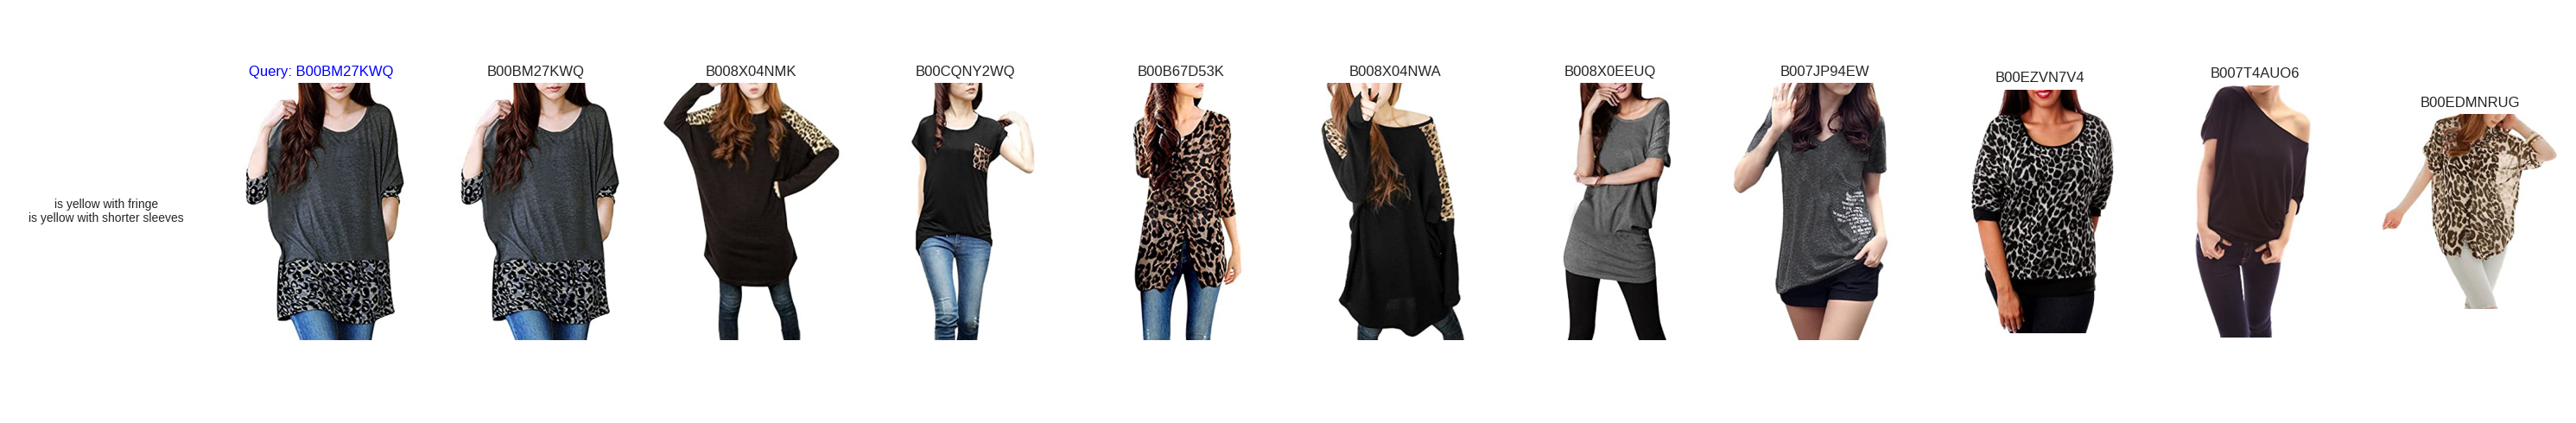

In [47]:
plot_retrieval_results_of_i(sorted_indices_toptee_origin, image_index_names_toptee_origin, target_names_toptee_origin, ground_truth_toptee, top_k=10, i=2, directory=DATASET_IMAGE_DIR)